### Installing packages and loading

In [162]:
# install.packages("reshape")
# install.packages("BiocManager")
# install.packages("ggrepel")
# install.packages("corrplot")
# install.packages("pheatmap")
# BiocManager::install("ComplexHeatmap")
# BiocManager::install("AnnotationDbi")
# BiocManager::install("org.Hs.eg.db")
# BiocManager::install('PCAtools')
# install.packages("rlang")
# install.packages("gplots")
# install.packages("factoextra")
# install.packages("corrr")
# install.packages("ggcorrplot")
# install.packages("FactoMineR")
library('corrr')
library(ggcorrplot)
library("FactoMineR")
library(PCAtools)
library(reshape)
library("org.Hs.eg.db")
library(tibble)
library(dplyr)
library(ggplot2)
library(gplots)
library(ggrepel)
library(pheatmap)
library(dplyr, warn.conflicts = FALSE)
library(rlang)
library(factoextra)
library(vctrs)

### reading infect.txt and plotting

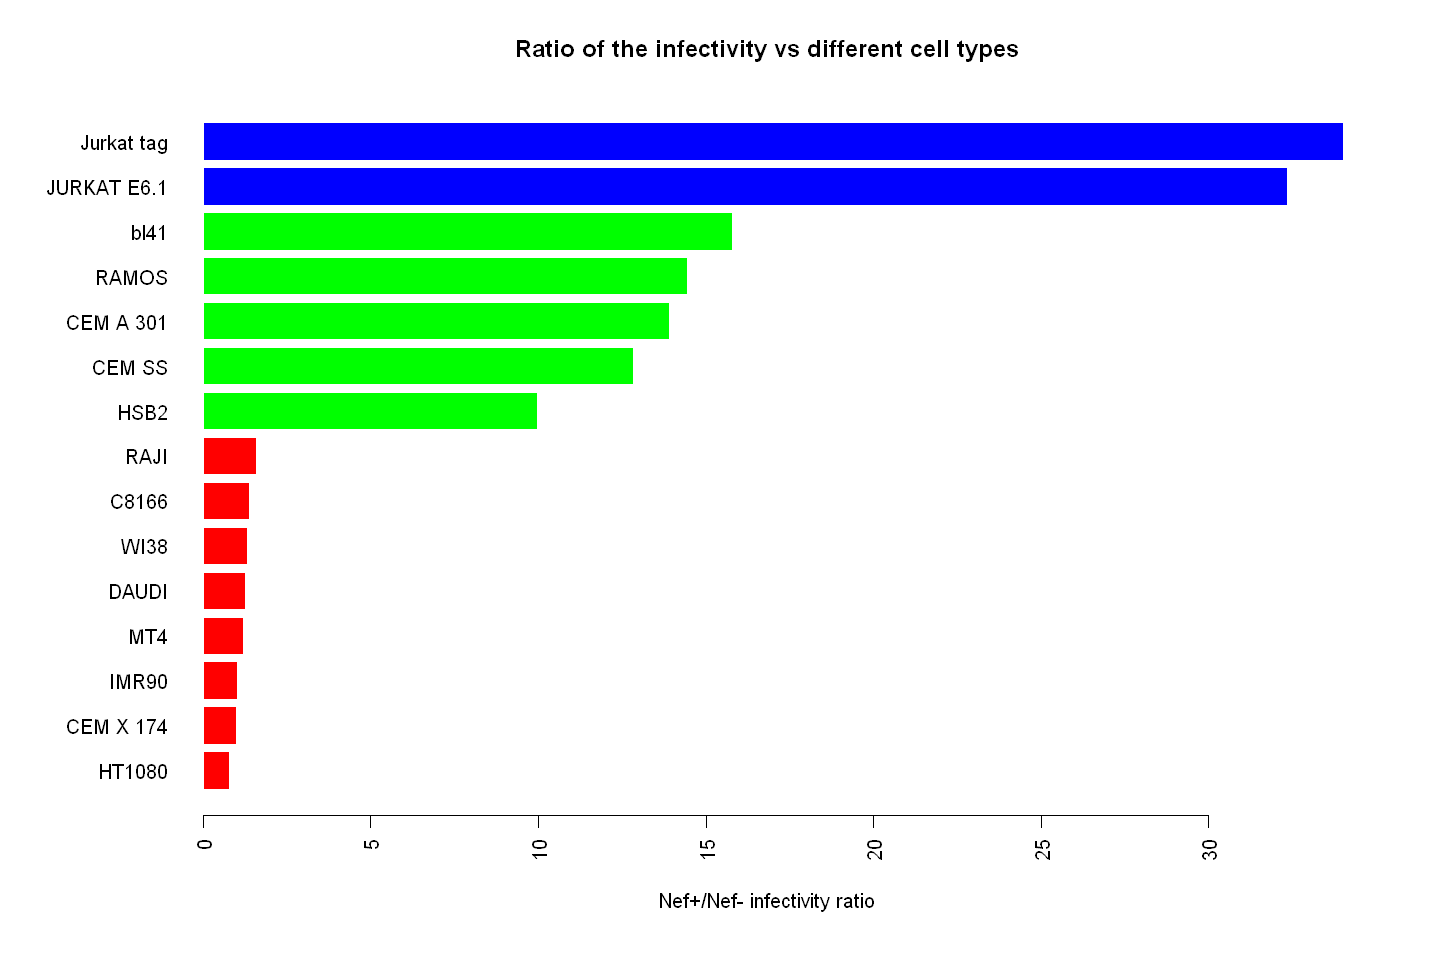

In [163]:
# ------------Code for Ratio of the infectivity vs different cell types plot--------
setwd("D:/Study/SEMESTER 8/Biostats/datasets")
read.delim("infect.txt", fill=TRUE, header=FALSE ) -> infect_data
infect_data <- infect_data[order(infect_data$V2),]
infect_ratio <- infect_data$V2
names(infect_ratio) <- infect_data$V3

give_color <- function(value){
  if (value < 5) return("red")
  else if ( value < 25) return("green")
  else return("blue")
}
par(mar = c(6, 8, 4, 4)) # for margin around plot

color_vector <- unlist(lapply(infect_data$V2, give_color))
infect_data$V4 <- color_vector

barplot(infect_ratio, horiz = TRUE,
        las=2, xlab = "Nef+/Nef- infectivity ratio", col=color_vector,
        main = "Ratio of the infectivity vs different cell types", 
        border = 0)

### Reading htseq files and merging to dataframe

In [164]:
expression_df <- read.delim("SRR2166624.htseq",header = FALSE,col.names = c("ID","SRR2166624"))

# appending columns to expression_df from other htseq files using a for loop
for (i in 25:38){
  column_name <- paste("SRR21666",as.character(i), sep="")
  filename <- paste("SRR21666",as.character(i),".htseq", sep="") # generating the given filenames using a loop
  temp_df <- read.delim(filename,header = FALSE,col.names = c("ID",column_name)) 
  expression_df[,column_name] <- temp_df[,column_name] # appending new columns to expression_df 
}
# Changing column names to Cell line names from infect.txt file
colnames(expression_df) <- c( "ID",infect_data[order(infect_data$V1,decreasing=FALSE),]$V3)
# getting rid of summary values in the end of the dataframe
clean_df <- expression_df[1:58302,]

In [167]:
head(clean_df,10)

,ID,MT4,HSB2,HT1080,RAJI,CEM SS,DAUDI,C8166,RAMOS,IMR90,CEM A 301,CEM X 174,WI38,JURKAT E6.1,bl41,Jurkat tag,gene_names
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,ENSG00000000003,0,64,71,0,0,0,2,0,963,0,0,572,0,0,4,TSPAN6
2,ENSG00000000005,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,TNMD
3,ENSG00000000419,535,707,535,888,706,424,655,542,1021,29,415,645,771,410,1128,DPM1
4,ENSG00000000457,643,643,165,604,490,475,292,362,470,13,109,496,1630,477,887,SCYL3
5,ENSG00000000460,885,826,143,648,808,654,354,555,441,22,140,317,2339,593,1428,C1orf112
6,ENSG00000000938,9,8,1,2977,3,1188,14,134,0,0,24,0,74,10,16,FGR
7,ENSG00000000971,1,228,5,0,16,0,0,0,971,2,0,2560,4,0,4,CFH
8,ENSG00000001036,174,12,334,0,4,4,2,2,2766,0,8,2069,55,12,15,FUCA2
9,ENSG00000001084,549,635,79,491,987,769,298,388,1231,26,105,1855,1319,769,1282,GCLC


### Cleaning up data and adding gene names column

In [168]:
clean_df$gene_names <- mapIds(org.Hs.eg.db, keys=clean_df$ID, keytype="ENSEMBL", column="SYMBOL") # adding new column with gene names
clean_df[is.na(clean_df$gene_names),17] <- "Unknown" # unknown gene names are converted to NA # adding new column gene names from accession number

cdf <- as.data.frame(sapply(clean_df[,c(-1,-17)], as.numeric))
cdf %>% mutate(zc = rowSums(. == 0)) -> cdf # counting zeros row wise
nonzero_cdf <- cdf[cdf$zc < 7,][-16] # filtering genes with non-zero expression in at least 50% cell lines

head(nonzero_cdf,10)

'select()' returned 1:many mapping between keys and columns



,MT4,HSB2,HT1080,RAJI,CEM SS,DAUDI,C8166,RAMOS,IMR90,CEM A 301,CEM X 174,WI38,JURKAT E6.1,bl41,Jurkat tag
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,535,707,535,888,706,424,655,542,1021,29,415,645,771,410,1128
4,643,643,165,604,490,475,292,362,470,13,109,496,1630,477,887
5,885,826,143,648,808,654,354,555,441,22,140,317,2339,593,1428
6,9,8,1,2977,3,1188,14,134,0,0,24,0,74,10,16
7,1,228,5,0,16,0,0,0,971,2,0,2560,4,0,4
8,174,12,334,0,4,4,2,2,2766,0,8,2069,55,12,15
9,549,635,79,491,987,769,298,388,1231,26,105,1855,1319,769,1282
10,586,1015,232,1238,1116,616,994,535,1321,36,186,1063,3303,454,1657
11,44,144,58,266,19,67,79,63,489,0,2,318,50,131,51


### Plotting overall expression of significant genes profile as heatmap

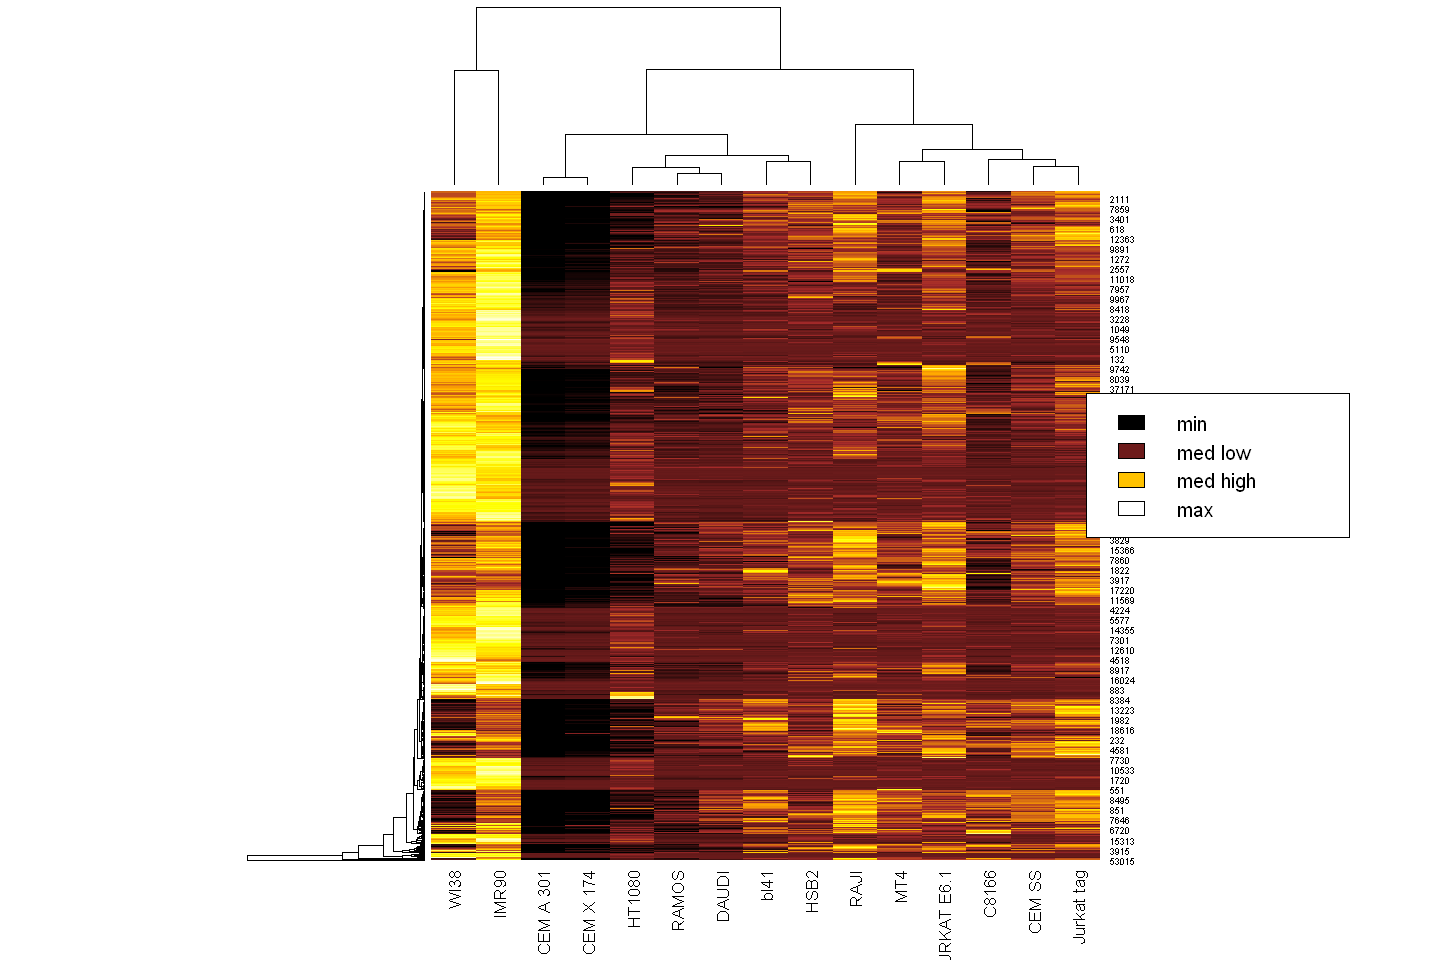

In [169]:
my_colors <- colorRampPalette(c("black", "black","brown","orange","yellow","white"))
heatmap(as.matrix(nonzero_cdf[order(nonzero_cdf$IMR90, decreasing = TRUE), ][0:1000,0:15]), col=my_colors(1000))
legend(x="right", legend=c("min", "med low", "med high", "max"),fill=my_colors(4))


### Normalizing data -> getting RPM values

In [170]:
rpm_df <- clean_df

for (name in (colnames(rpm_df)[c(-17,-1)])){
col_total = sum(as.numeric(rpm_df[,name]))
current_col = rpm_df[,name]
rpm_df[,name] <- unlist(lapply(current_col, FUN = function(x) x*1000000/col_total))
}
rpm_df$name <- NULL
head(rpm_df,10)

,ID,MT4,HSB2,HT1080,RAJI,CEM SS,DAUDI,C8166,RAMOS,IMR90,CEM A 301,CEM X 174,WI38,JURKAT E6.1,bl41,Jurkat tag,gene_names
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000000003,0.00000000,4.81296698,9.9611068,0.00000,0.0000000,0.000000,0.2057234,0.0000000,35.44316,0.000000,0.000000,24.70044,0.0000000,0.0000000,0.2356532,TSPAN6
2,ENSG00000000005,0.00000000,0.07520261,0.0000000,0.00000,0.0000000,0.000000,0.0000000,0.0000000,0.00000,0.000000,0.000000,0.00000,0.0000000,0.0000000,0.0000000,TNMD
3,ENSG00000000419,40.02970429,53.16824456,75.0590441,49.63045,57.0600174,44.760829,67.3744100,65.0361629,37.57784,94.991336,162.591306,27.85277,40.2618409,32.7002877,66.4541978,DPM1
4,ENSG00000000457,48.11046702,48.35527758,23.1490510,33.75765,39.6025616,50.144797,30.0356148,43.4374372,17.29832,42.582323,42.704704,21.41857,85.1190670,38.0439932,52.2560935,SCYL3
5,ENSG00000000460,66.21736129,62.11735502,20.0625109,36.21681,65.3038159,69.041468,36.4130399,66.5960708,16.23098,72.062393,54.850079,13.68888,122.1432501,47.2957819,84.1281866,C1orf112
6,ENSG00000000938,0.67339689,0.60162087,0.1402973,166.38496,0.2424647,125.414777,1.4400637,16.0790513,0.00000,0.000000,9.402871,0.00000,3.8643012,0.7975680,0.9426127,FGR
7,ENSG00000000971,0.07482188,17.14619485,0.7014864,0.00000,1.2931449,0.000000,0.0000000,0.0000000,35.73760,6.551127,0.000000,110.54743,0.2088811,0.0000000,0.2356532,CFH
8,ENSG00000001036,13.01900663,0.90243131,46.8592911,0.00000,0.3232862,0.422272,0.2057234,0.2399858,101.80246,0.000000,3.134290,89.34478,2.8721158,0.9570816,0.8836994,FUCA2
9,ENSG00000001084,41.07721057,47.75365671,11.0834850,27.44206,79.7708741,81.181787,30.6527850,46.5572531,45.30688,85.164646,41.137559,80.10371,68.8785579,61.3329786,75.5268454,GCLC


### Correlation Plot

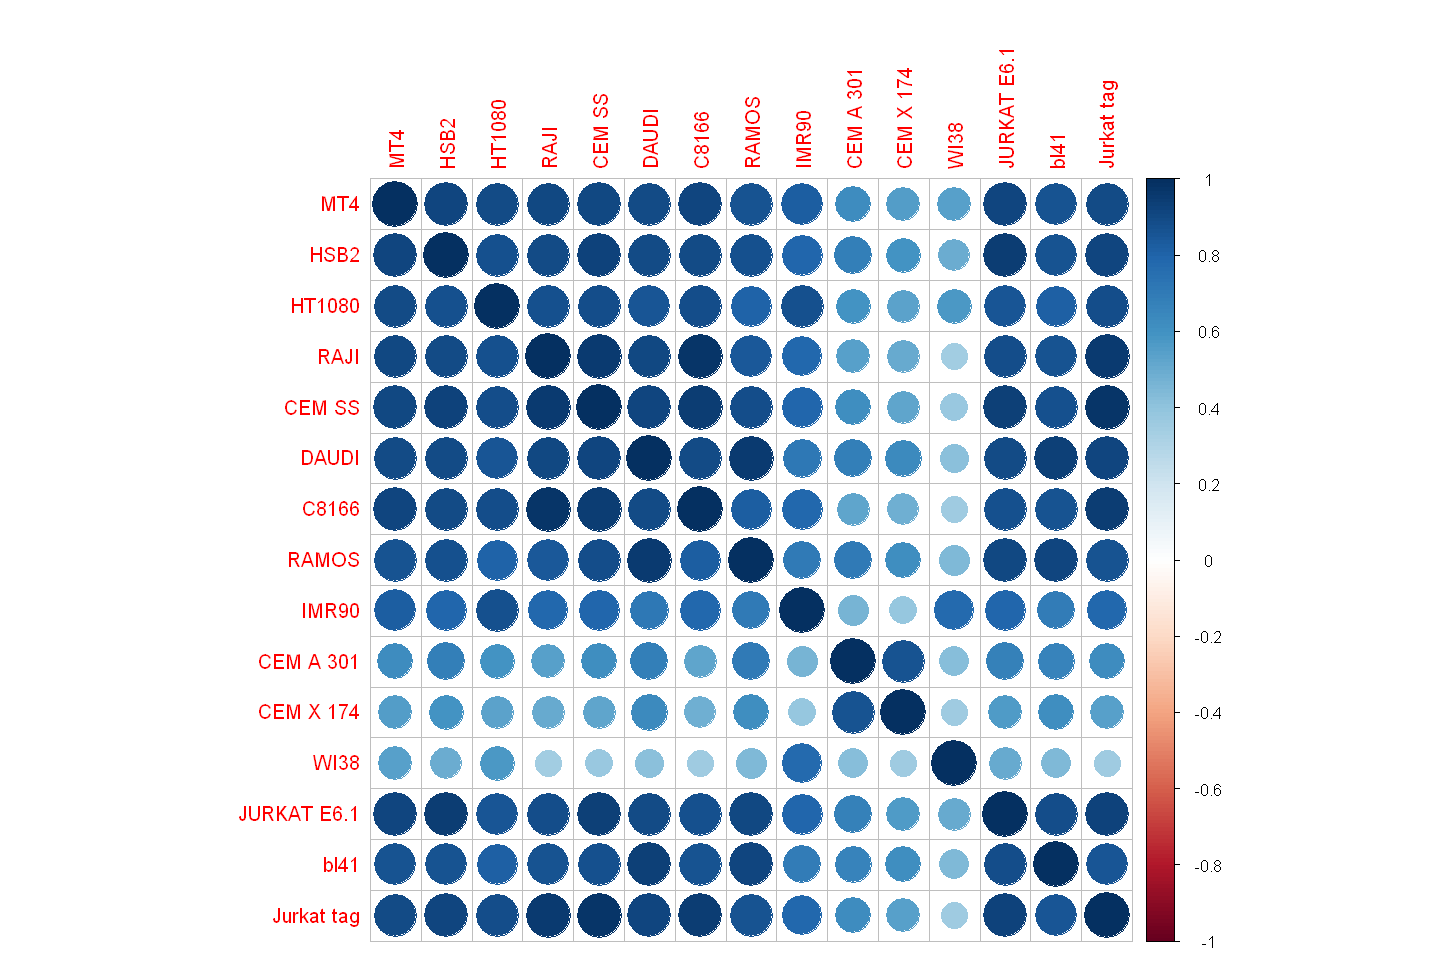

In [171]:
d <- cor(rpm_df[,c(-1,-17)])
library(corrplot)
corrplot(d)

### Establishing correlation of infect ratio with expression data

In [172]:
find_cor <- function(onerow){
sorted_infect_ratio <- arrange(infect_data,V1)$V2
cor_value <- suppressWarnings(cor.test(sorted_infect_ratio,as.numeric(as.vector(unlist(onerow))[c(-1,-17)])))
return(as.numeric(cor_value$estimate))
}

result_df <- rpm_df
result_df$cor_with_infect_ratio <- as.vector(apply(rpm_df,1,find_cor))

In [184]:
result_df_sorted <- arrange(result_df, desc(cor_with_infect_ratio))
result_df_sorted <- subset(result_df_sorted, !is.na(cor_with_infect_ratio))
result_df_sorted <- result_df_sorted[result_df_sorted$gene_names != "Unknown",]
head(result_df_sorted,10)

,ID,MT4,HSB2,HT1080,RAJI,CEM SS,DAUDI,C8166,RAMOS,IMR90,CEM A 301,CEM X 174,WI38,JURKAT E6.1,bl41,Jurkat tag,gene_names,cor_with_infect_ratio
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,ENSG00000164300,8.0059409,201.843803,18.6595381,6.7068174,128.910379,3.800448,3.6001593,134.032092,20.79479013,189.982672,10.9700158,31.48010923,397.500821,115.009304,322.903775,SERINC5,0.9556150
2,ENSG00000136104,104.4513405,165.445740,18.6595381,57.7904099,182.171783,113.802297,20.5723389,162.110435,14.02268148,186.707109,97.9465698,12.82522969,329.040025,180.968177,327.204446,RNASEH2B,0.9447338
3,ENSG00000152580,9.6520222,20.154299,2.8059456,4.8624426,8.971193,0.105568,0.2057234,12.959235,0.07360988,9.826690,0.7835726,0.47500851,37.441945,12.123033,34.758845,IGSF10,0.9341112
6,ENSG00000100084,16.5356349,15.642143,7.2954585,13.0224038,19.397173,19.530079,7.9203505,20.398796,7.32418272,19.653380,7.8357256,8.11832721,35.718676,19.699929,35.171238,HIRA,0.9254545
7,ENSG00000144893,68.3871957,157.850276,14.0297279,36.3285943,73.628436,0.211136,1.7486488,85.794938,0.66248889,104.818026,0.7835726,1.12274738,215.774224,81.192422,248.731935,MED12L,0.9243723
8,ENSG00000144736,19.3788662,74.751393,36.3369952,48.7920966,103.936519,37.159934,28.1841043,58.316559,21.56769383,65.511266,39.9622005,23.36178202,149.820002,48.651648,200.187380,SHQ1,0.9230484
9,ENSG00000196839,0.1496438,114.458371,23.7102401,59.5788946,116.867968,17.524287,0.2057234,70.675830,4.41659259,157.227039,92.8533481,6.04556282,616.303821,78.959231,579.117699,ADA,0.9217021
10,ENSG00000172995,0.0000000,0.000000,0.1402973,0.3353409,49.058683,1.583520,0.0000000,2.159873,0.07360988,85.164646,0.3917863,0.04318259,224.495012,41.393779,163.896789,ARPP21,0.9106440
11,ENSG00000152475,1.7957251,4.136143,0.8417837,2.4032762,5.657509,2.322496,1.9543722,2.999823,2.46593086,3.275563,0.0000000,0.77728665,7.415281,4.386624,7.010682,ZNF837,0.9074607


In [209]:
tail(result_df_sorted,10)

,ID,MT4,HSB2,HT1080,RAJI,CEM SS,DAUDI,C8166,RAMOS,IMR90,CEM A 301,CEM X 174,WI38,JURKAT E6.1,bl41,Jurkat tag,gene_names,cor_with_infect_ratio
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
45675,ENSG00000212978,9.726844,0.00000000,14.170025,16.934714,3.960256,10.979071,12.651988,8.879476,8.833185,0.000000,4.701435,9.716083,0.2611014,7.337626,0.1767399,C2orf74-DT,-0.7101401
45676,ENSG00000104312,10.699528,0.07520261,31.987780,39.011321,3.717791,22.485983,20.058030,20.038818,23.518356,0.000000,29.383971,23.793608,0.1566609,16.350144,0.0589133,RIPK2,-0.7134174
45677,ENSG00000062716,443.918197,224.40458522,425.381349,233.229575,51.160044,100.500730,266.926098,43.677423,337.133235,68.786830,353.391224,363.856516,79.2181746,89.965669,49.8995617,VMP1,-0.7183227
45678,ENSG00000169100,322.557112,279.15208457,280.734855,292.305458,156.632172,318.920909,339.340731,82.435136,152.630079,127.746969,301.283649,182.662362,116.3990186,209.999652,72.1098742,SLC25A6,-0.7360378
45679,ENSG00000275538,5.013066,8.42269221,12.767052,15.313900,10.102694,9.817823,12.240542,7.559554,15.384464,13.102253,14.496092,11.875213,2.9243360,4.625894,3.0634914,RNVU1-19,-0.7399350
45681,ENSG00000260916,11.821857,15.86775050,19.080430,13.916646,2.424647,12.245887,12.651988,5.039703,18.255249,3.275563,7.443939,15.113907,2.0365912,9.650573,2.0619654,CCPG1,-0.7540072
45682,ENSG00000125611,5.836106,2.85769914,6.032783,9.110094,1.778074,6.861920,6.377425,5.039703,6.183230,0.000000,3.134290,2.936416,0.0000000,2.233190,0.0589133,CHCHD5,-0.7599675
45683,ENSG00000198718,43.845620,10.30275743,21.605781,40.352685,22.145106,37.898910,39.498891,37.557784,34.559837,19.653380,28.600398,43.959878,10.8095993,22.810445,4.8898036,TOGARAM1,-0.7615864
45684,ENSG00000102390,21.773166,21.13193313,20.623700,25.318236,26.105362,16.151903,29.932753,2.639844,21.310059,19.653380,21.548245,18.093506,0.0000000,12.601574,0.0589133,PBDC1,-0.8006257


In [186]:
result_df_sorted[result_df_sorted$gene_names=="SERINC5",]

,ID,MT4,HSB2,HT1080,RAJI,CEM SS,DAUDI,C8166,RAMOS,IMR90,CEM A 301,CEM X 174,WI38,JURKAT E6.1,bl41,Jurkat tag,gene_names,cor_with_infect_ratio
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,ENSG00000164300,8.005941,201.8438,18.65954,6.706817,128.9104,3.800448,3.600159,134.0321,20.79479,189.9827,10.97002,31.48011,397.5008,115.0093,322.9038,SERINC5,0.955615


### Plotting SERINC5 expression

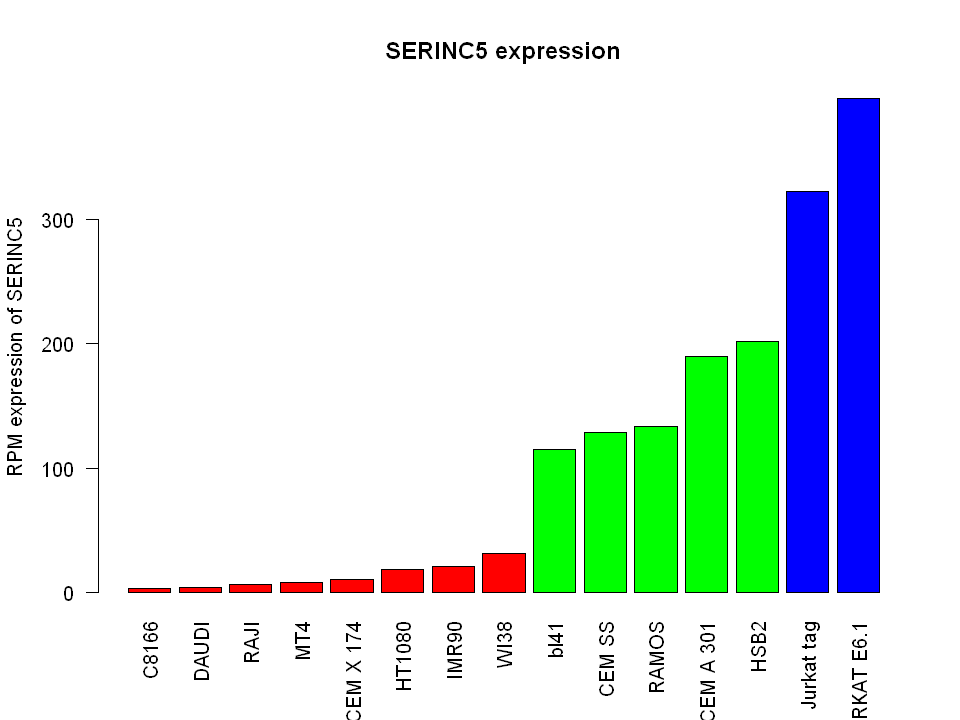

In [201]:
options(repr.plot.width=8, repr.plot.height=6)
SERINC5_expression <- as.vector(unlist(result_df_sorted[1,][,c(-1,-17,-18)]))
names(SERINC5_expression) <- colnames(result_df_sorted)[c(-1,-17,-18)]
barplot(sort(SERINC5_expression),las=2, col=arrange(infect_data,V2)$V4, main="SERINC5 expression", ylab="RPM expression of SERINC5")

### Plotting top positively and negatively correlated genes and comparing them with each other

In [177]:
correlation_plot <- function(rownumber){
gene_expression_rpm <- as.numeric(unlist(result_df_sorted[rownumber,]))[c(-1,-17,-18)]
sorted_infect_ratio <- arrange(infect_data,V1)$V2
sorted_infect_color <- arrange(infect_data,V1)$V4
plot(sorted_infect_ratio, gene_expression_rpm, pch=16, col=sorted_infect_color, main=result_df_sorted[rownumber,]$gene_names, xlab="Nef+/Nef- infectivity ratio", ylab=paste(result_df_sorted[rownumber,]$gene_names, " Expression RPM"))
abline(lm(gene_expression_rpm~sorted_infect_ratio), col="darkviolet")
}


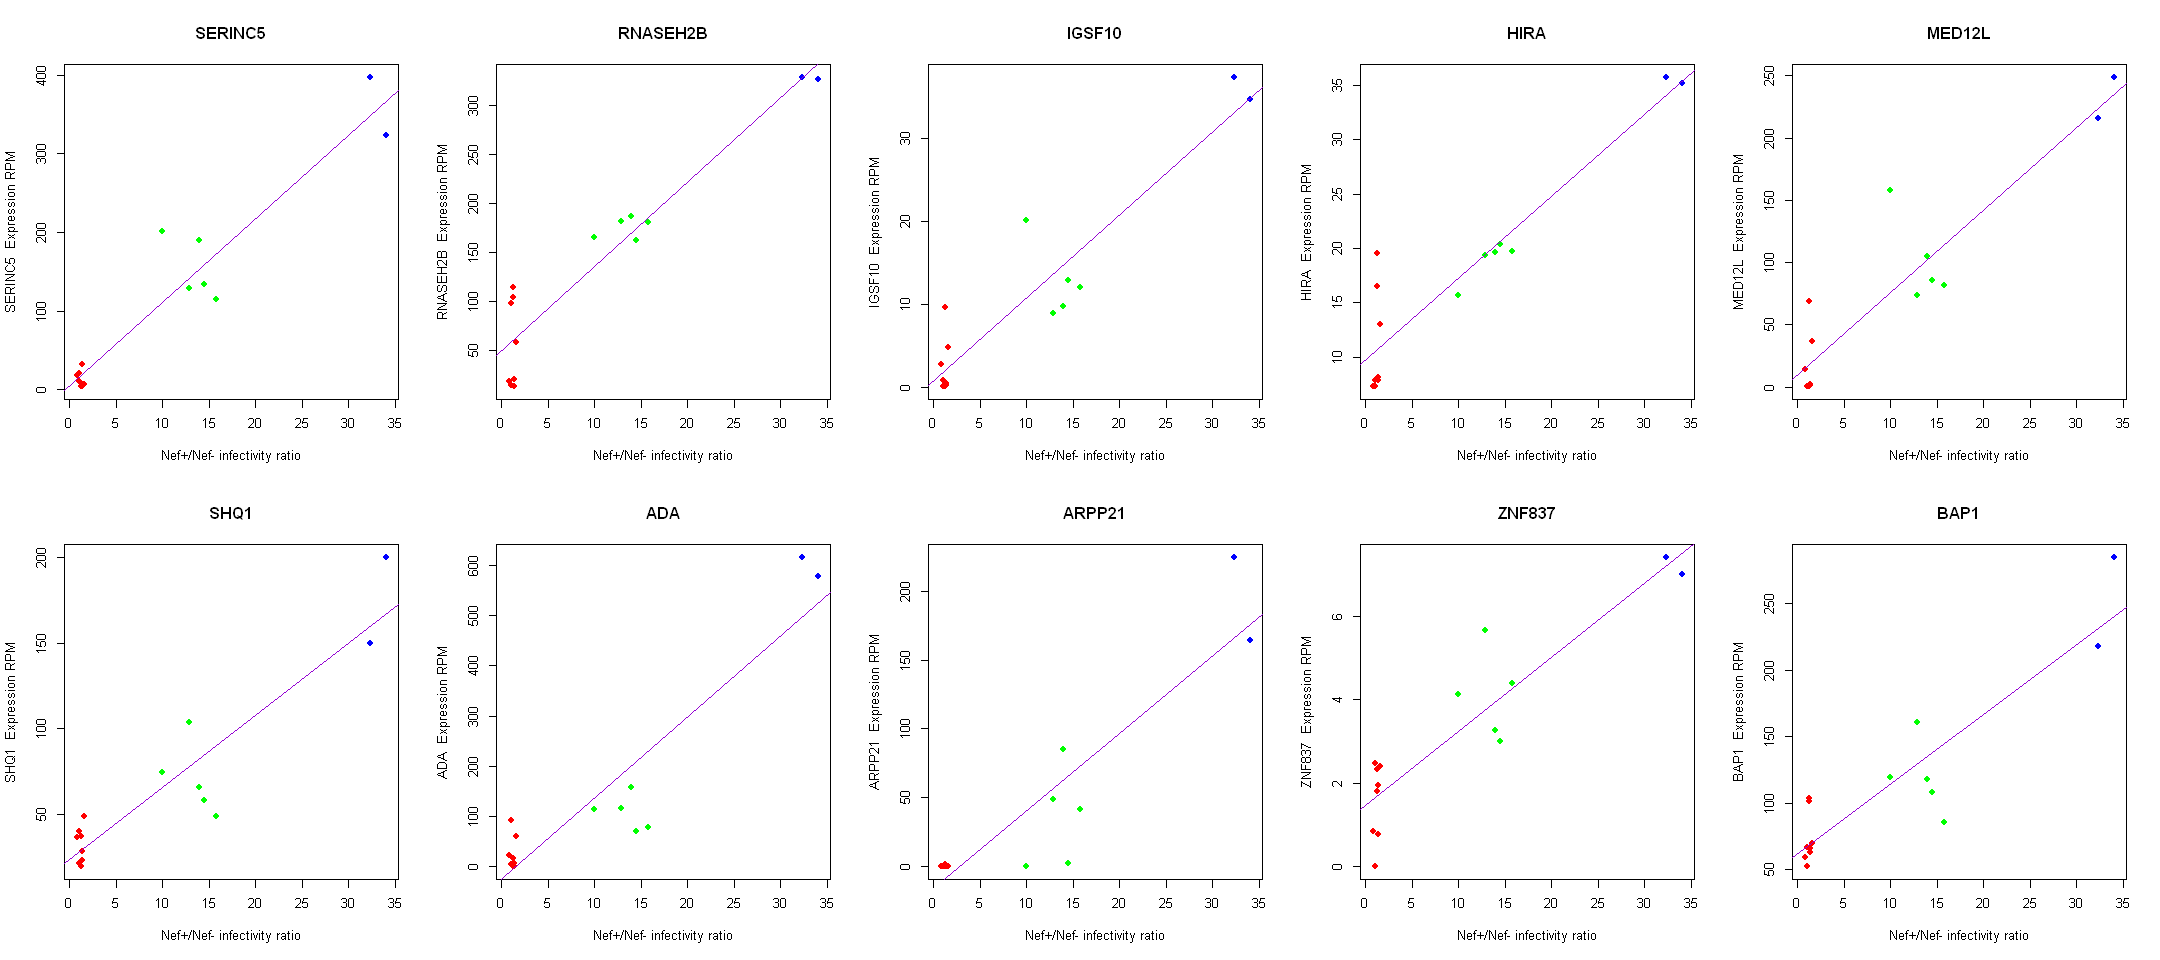

In [188]:

top_positively_correlated <- c(1:10)
top_negatively_correlated <- c(29321:29312)

options(repr.plot.width=18, repr.plot.height=8)
# positively correlated vs infectivity ratio
par(mfrow=c(2,5))
for (i in top_positively_correlated){
  suppressWarnings(correlation_plot(i))
}

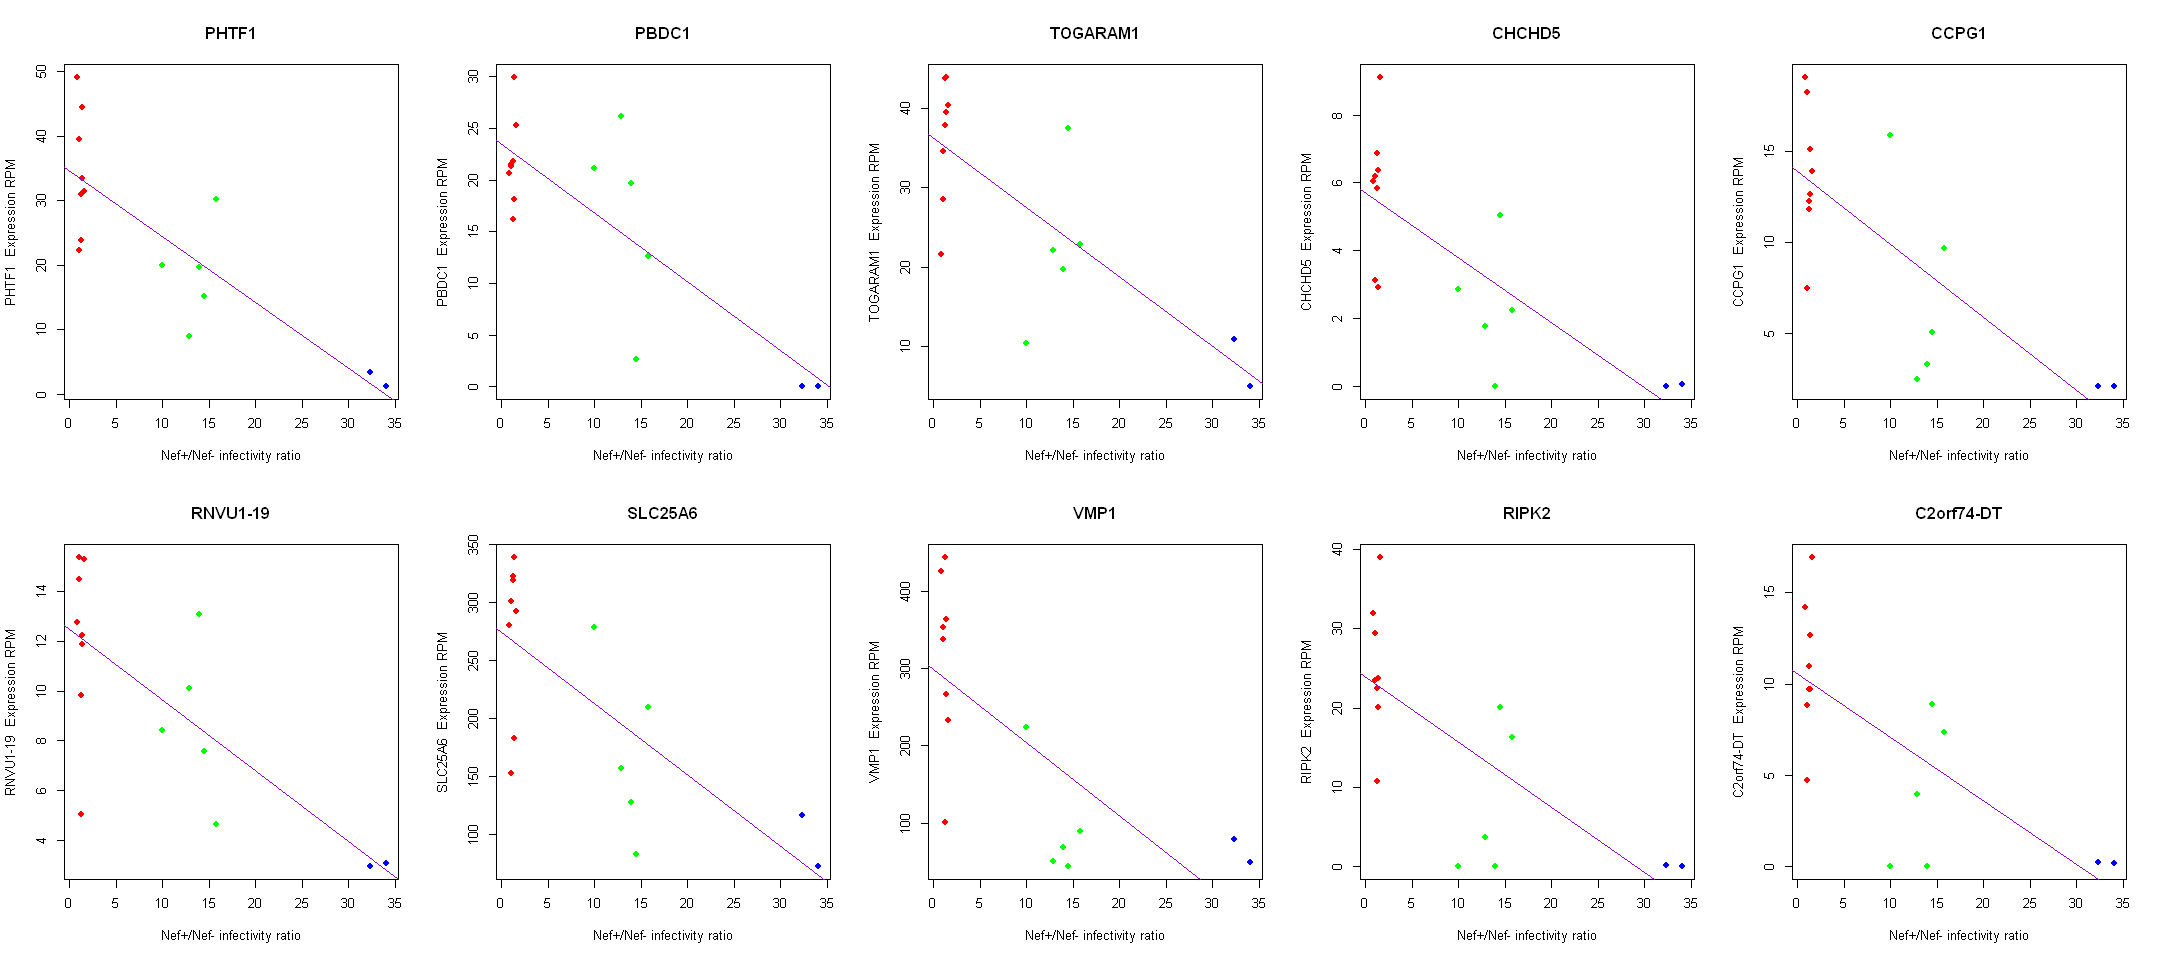

In [206]:
# negatively correlated vs infectivity ratio
options(repr.plot.width=18, repr.plot.height=8)
par(mfrow=c(2,5))
for (i in top_negatively_correlated){
  suppressWarnings(correlation_plot(i))
}

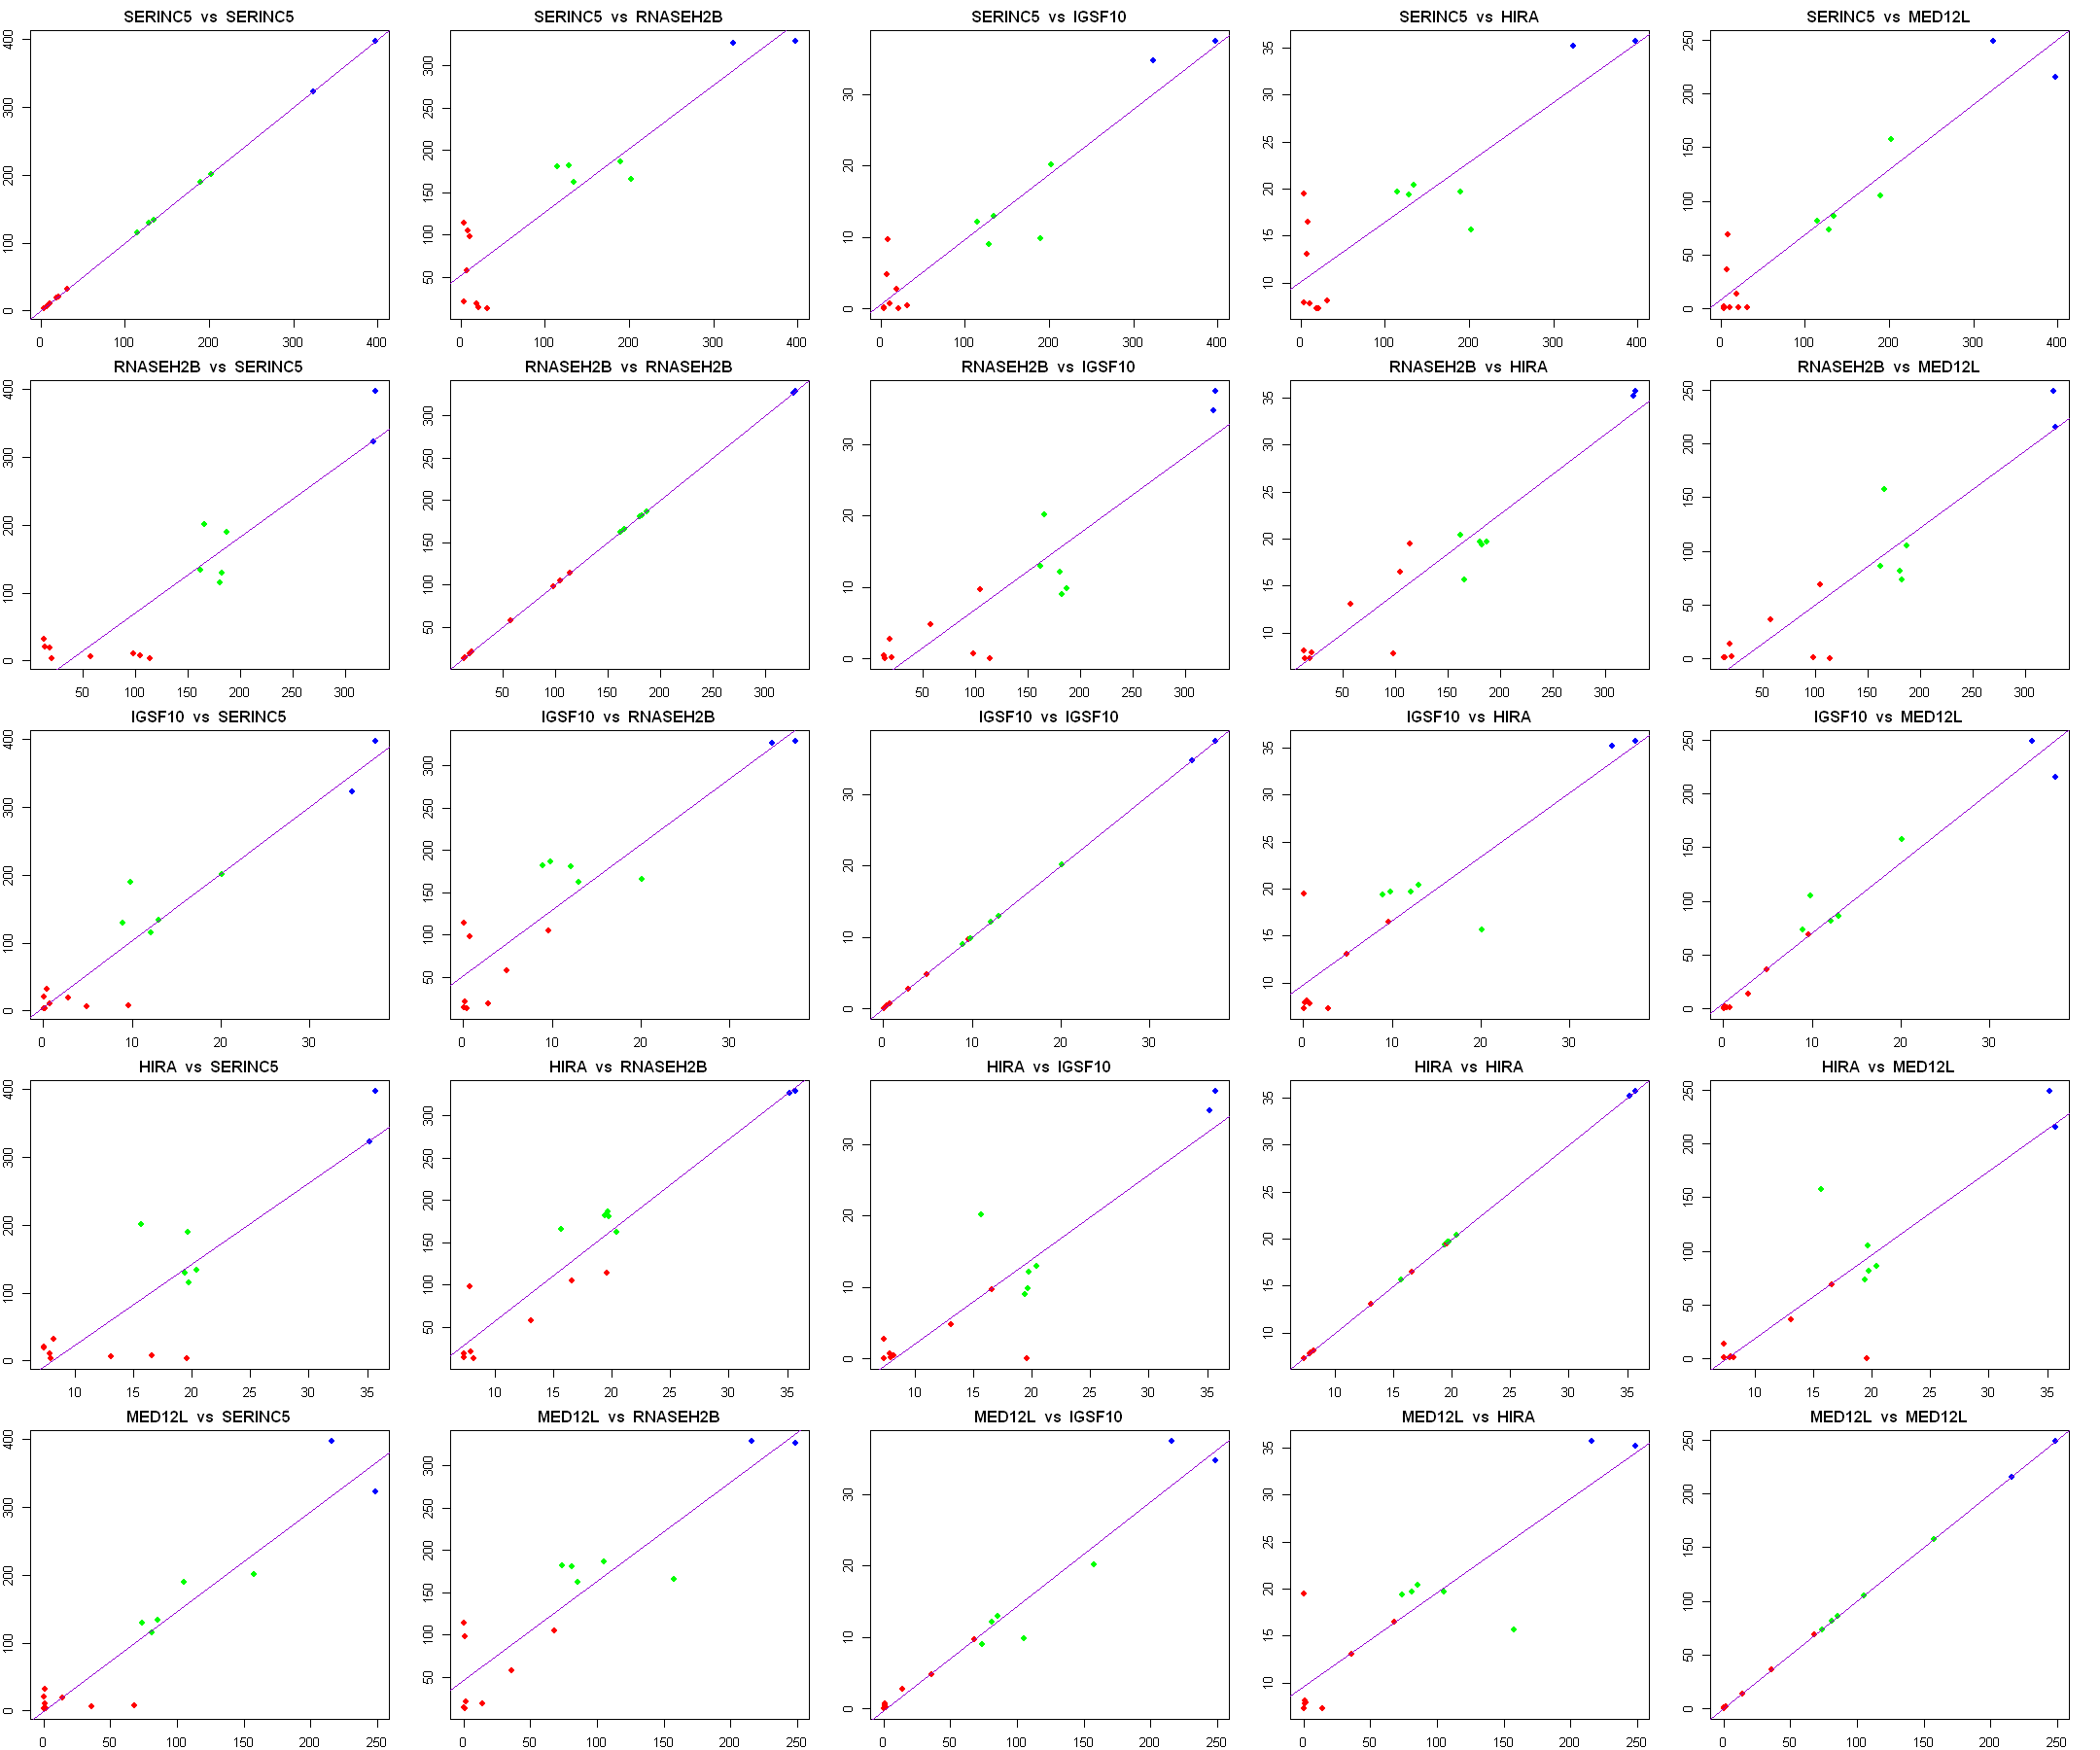

In [190]:
options(repr.plot.width=18, repr.plot.height=15)

compare_genes <- function(x,y){
x_axis = as.numeric(unlist(result_df_sorted[x,]))[c(-1,-17,-18)]
y_axis = as.numeric(unlist(result_df_sorted[y,]))[c(-1,-17,-18)]
x_label = paste(result_df_sorted[x,]$gene_names)
y_label = paste(result_df_sorted[y,]$gene_names)
title = paste(x_label ," vs ", y_label)
sorted_infect_color <- arrange(infect_data,V1)$V4
plot(x_axis, y_axis, main=title, xlab=x_label, ylab=y_label, pch=16, col=sorted_infect_color)
abline(lm(y_axis~x_axis), col="darkviolet")
}
# genewise comparisons
par(mfrow=c(5,5),mar = c(2, 2, 2, 2))
for (i in top_positively_correlated[1:5]){
  for (j in top_positively_correlated[1:5]){
    suppressWarnings(compare_genes(i,j))
  }
}

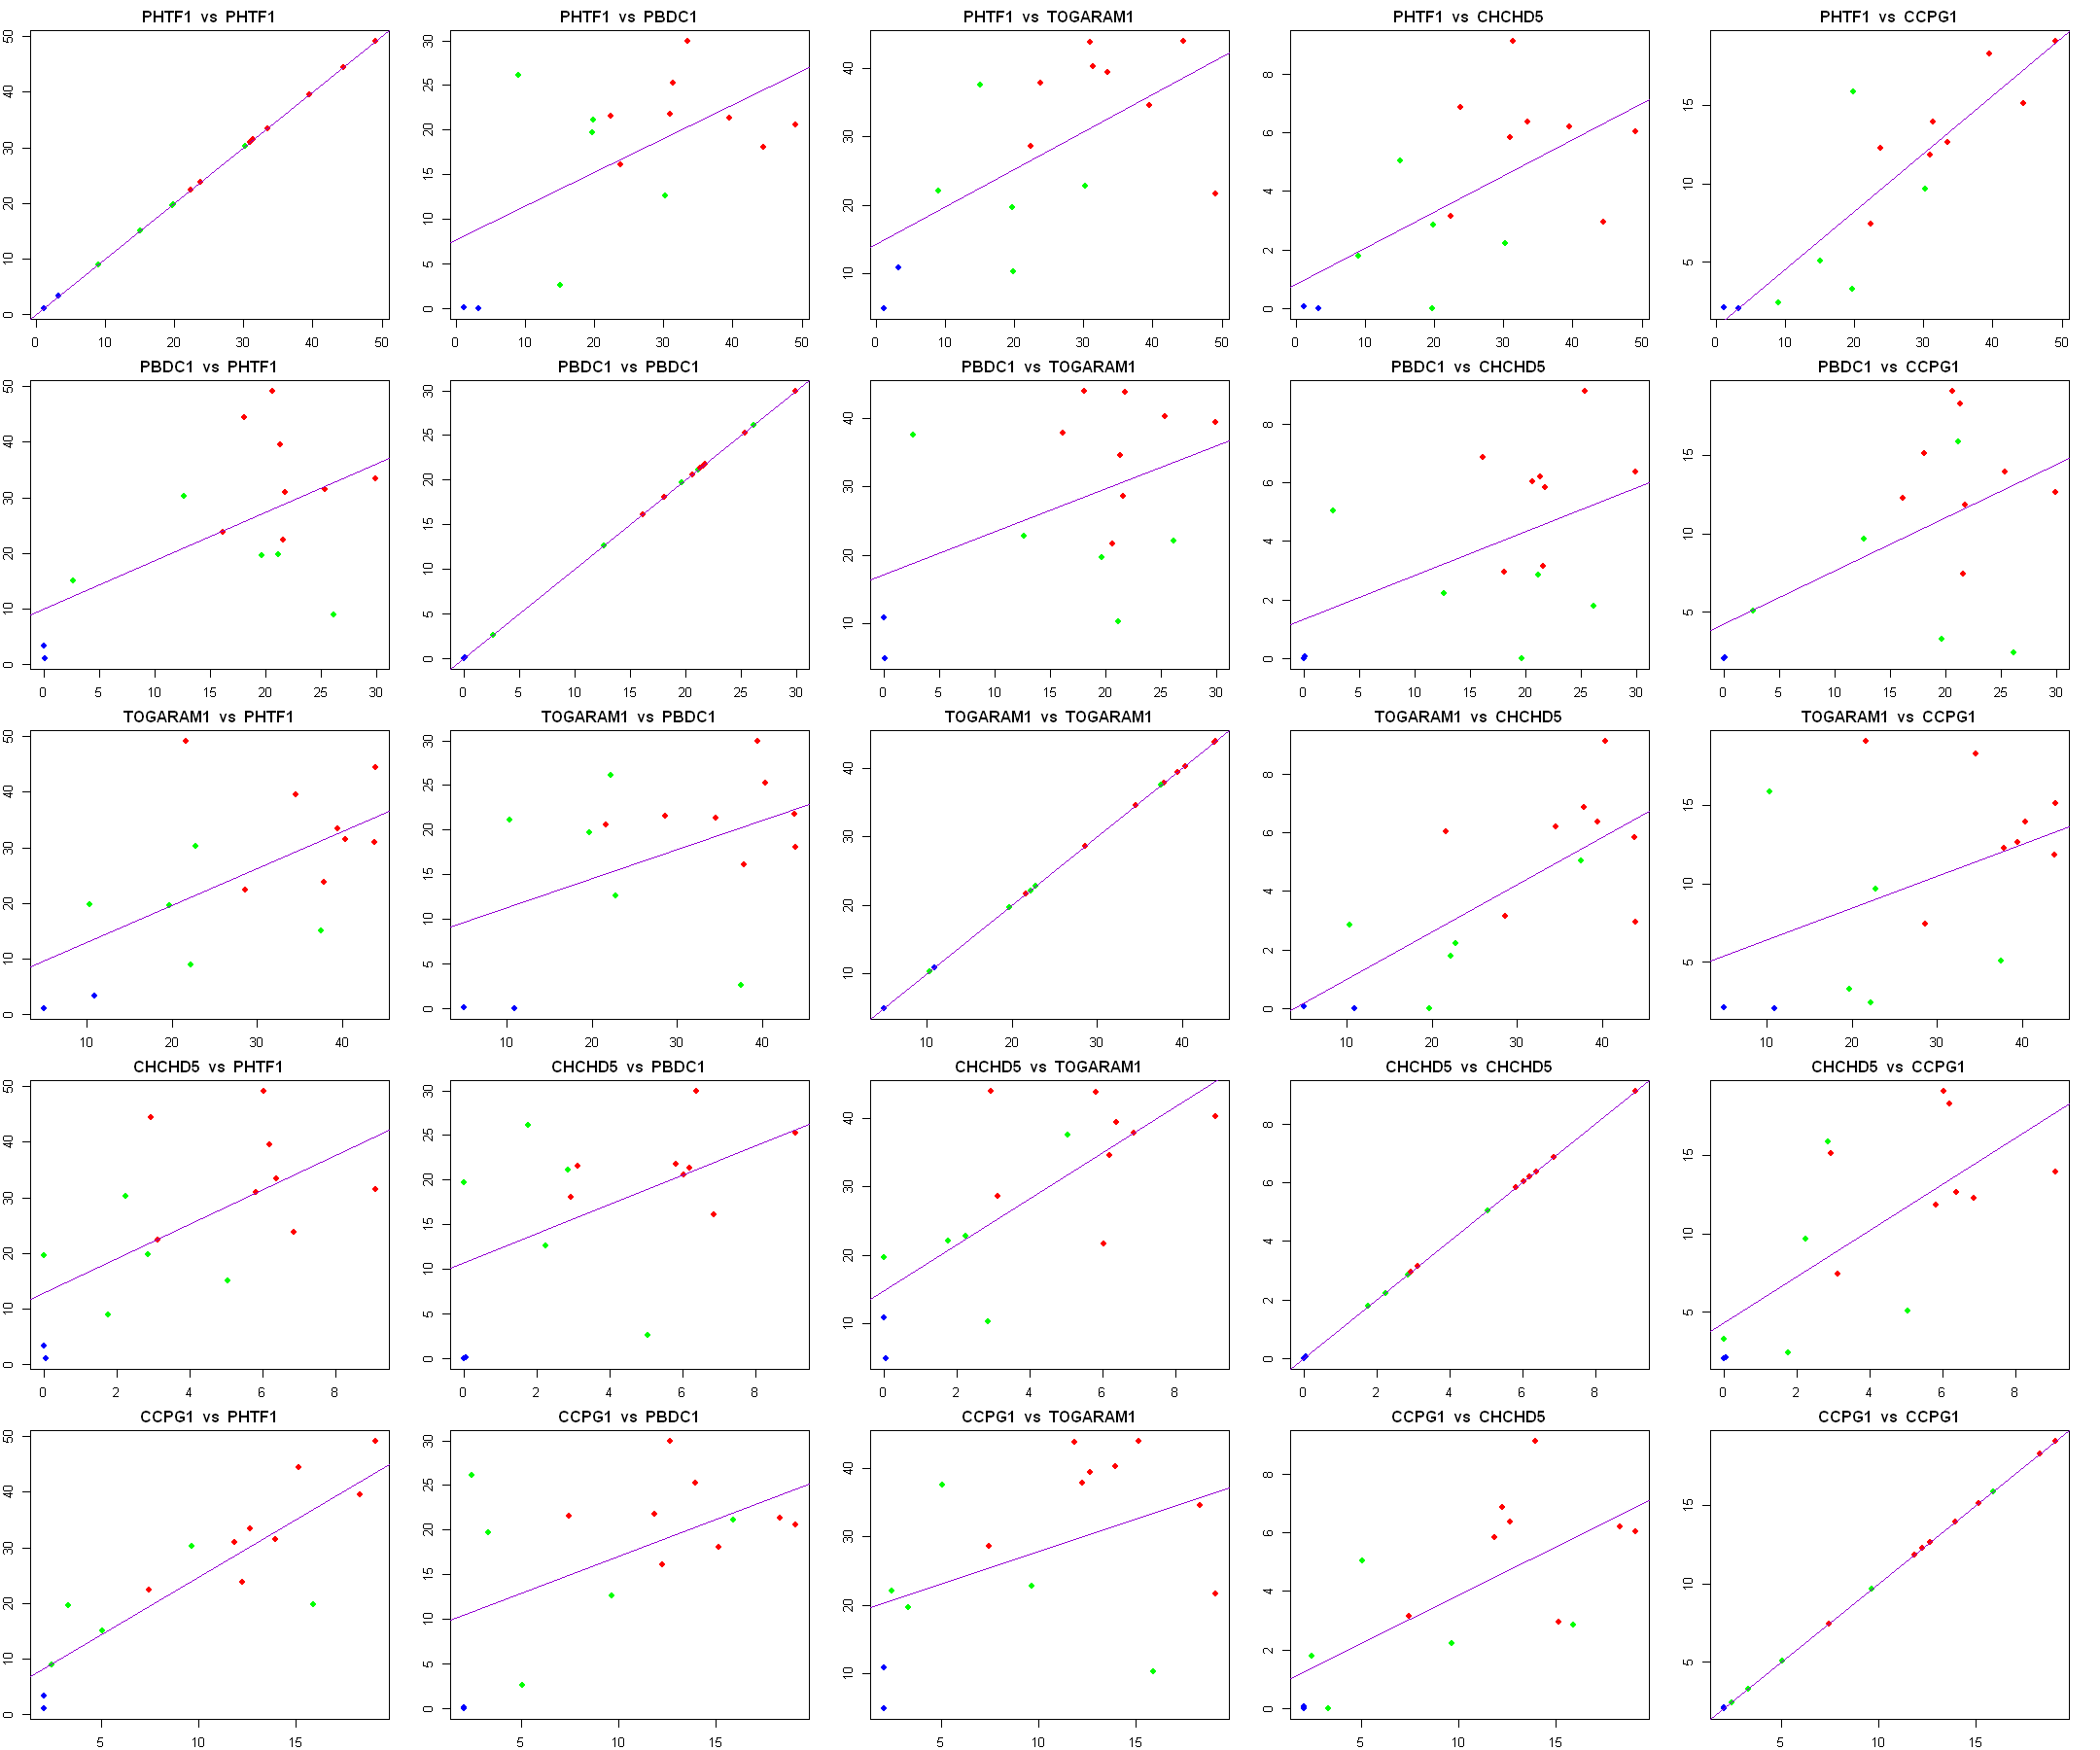

In [191]:
par(mfrow=c(5,5),mar = c(2, 2, 2, 2))
for (i in top_negatively_correlated[1:5]){
  for (j in top_negatively_correlated[1:5]){
    suppressWarnings(compare_genes(i,j))
  }
}

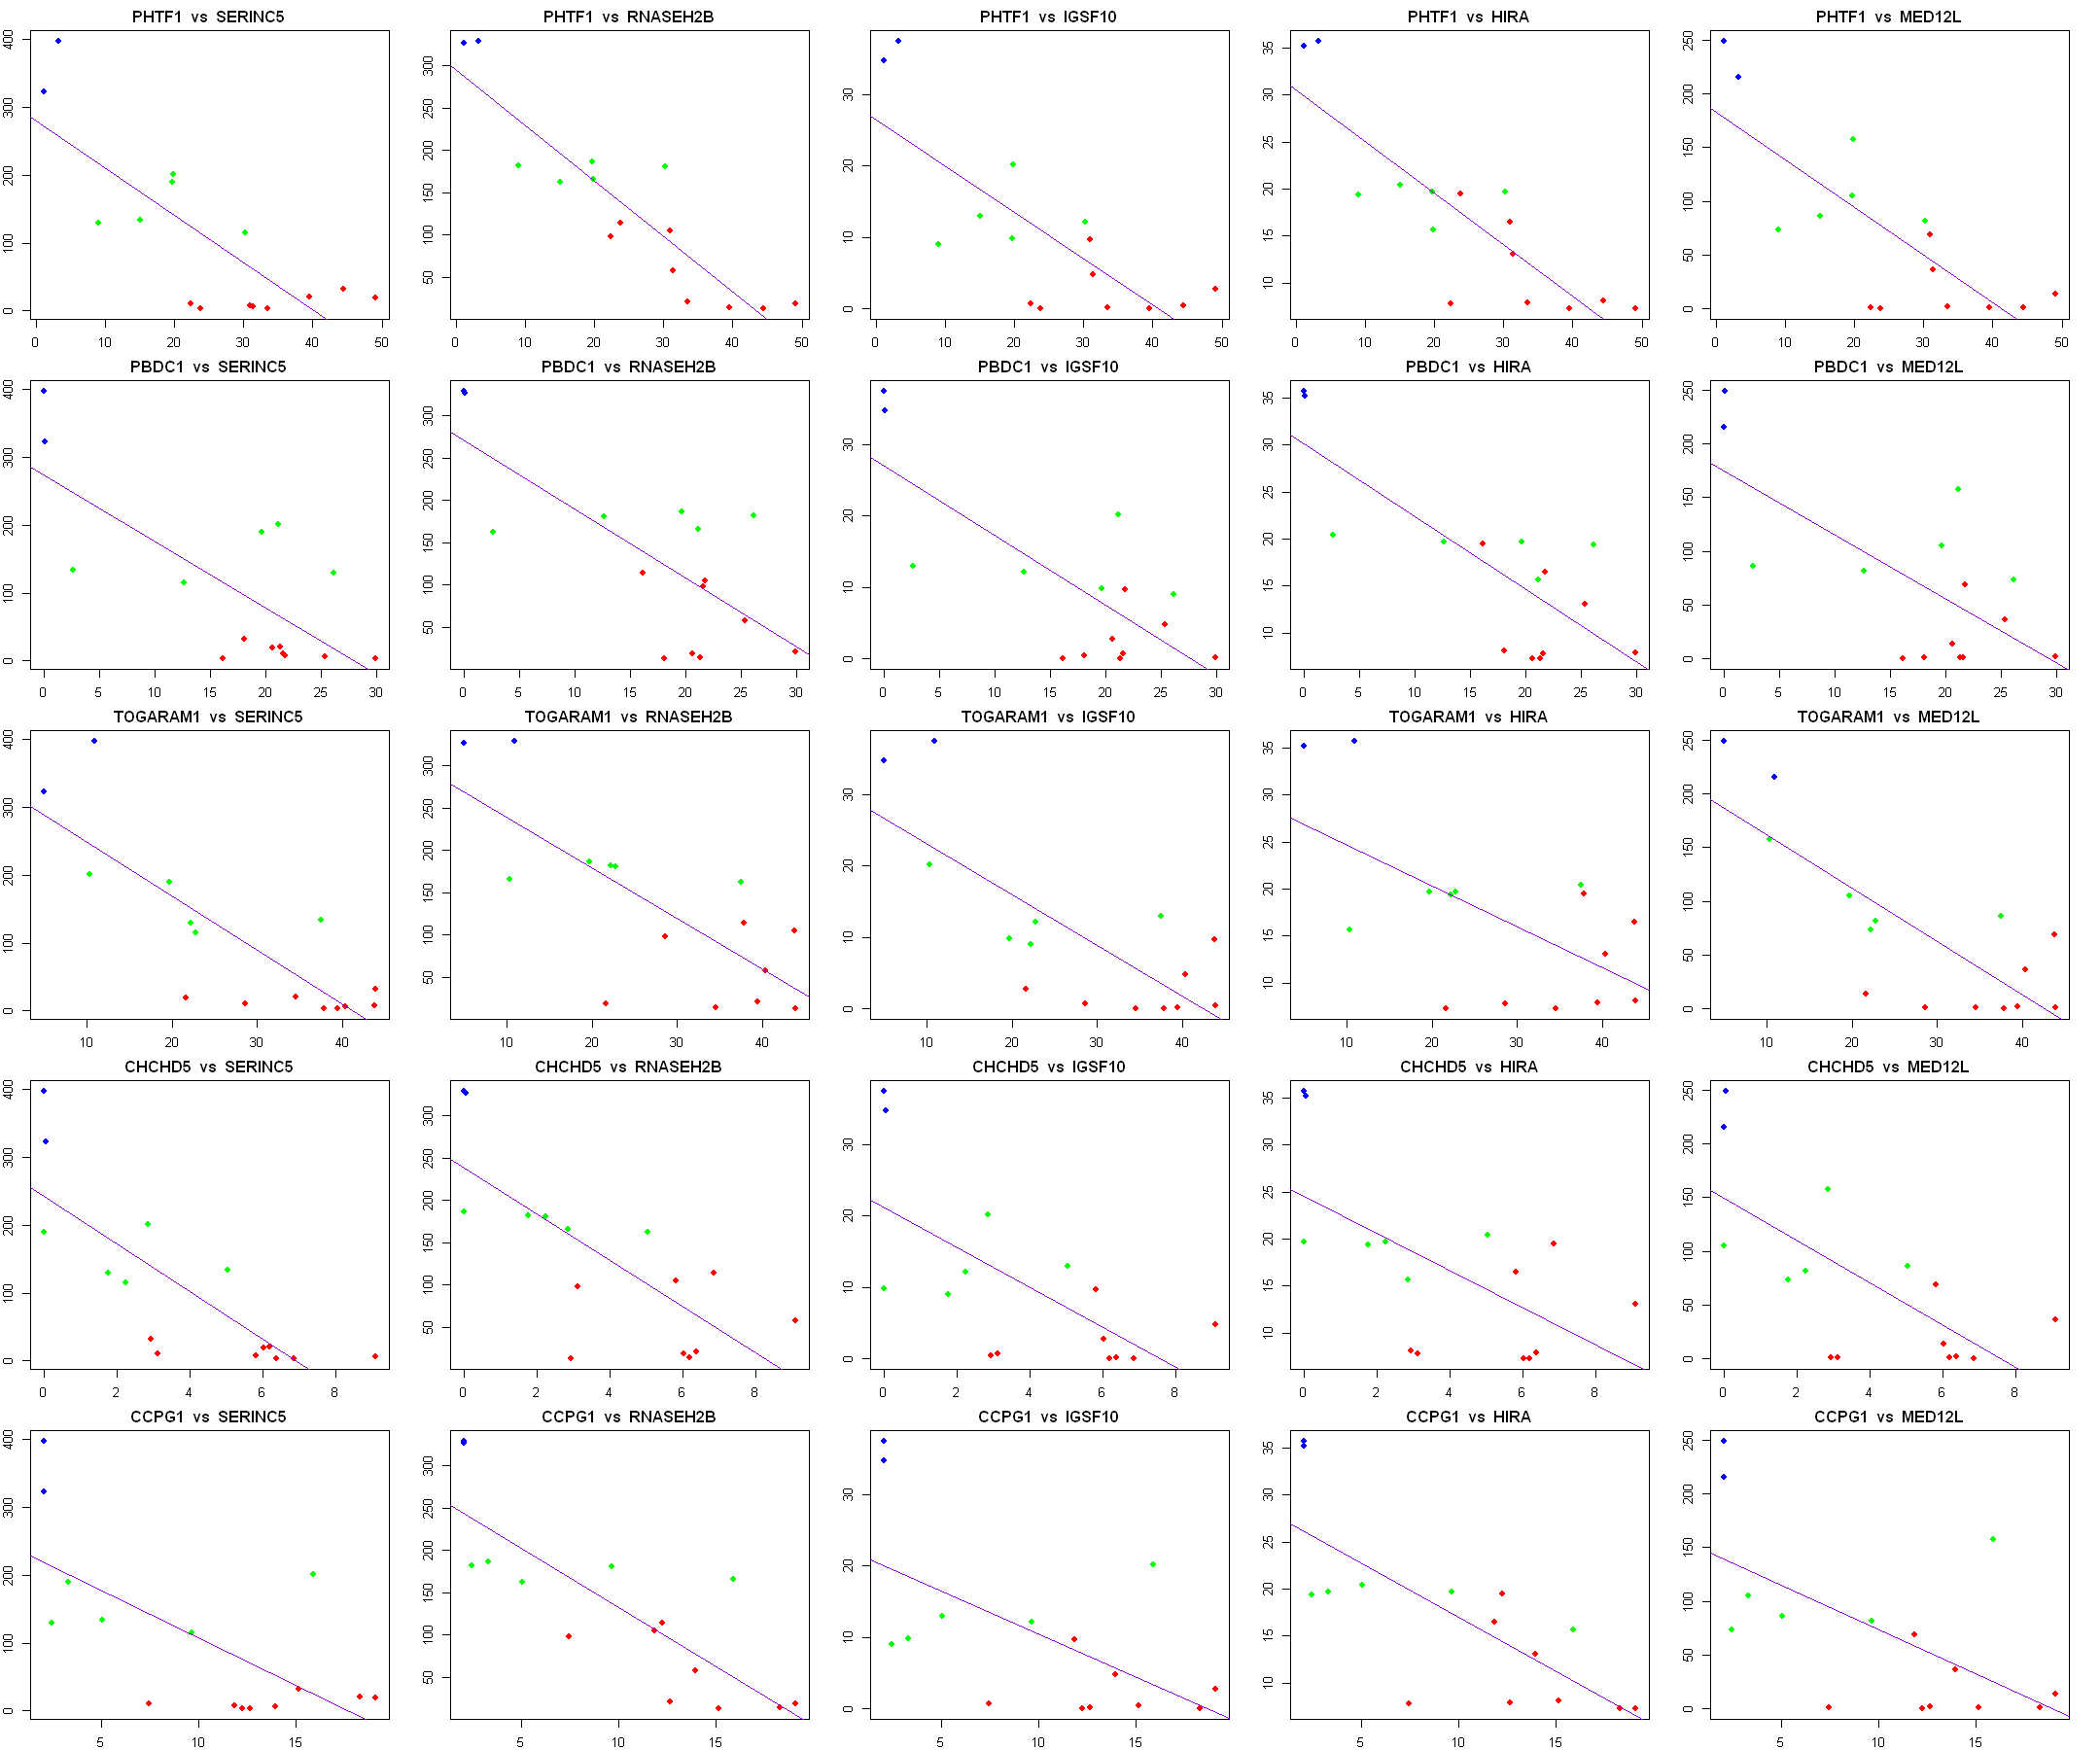

In [192]:
par(mfrow=c(5,5),mar = c(2, 2, 2, 2))
for (i in top_negatively_correlated[1:5]){
  for (j in top_positively_correlated[1:5]){
    suppressWarnings(compare_genes(i,j))
  }
}

### Expression profile of selected genes ( top 10 positive and top 10 negative ) in all cell lines

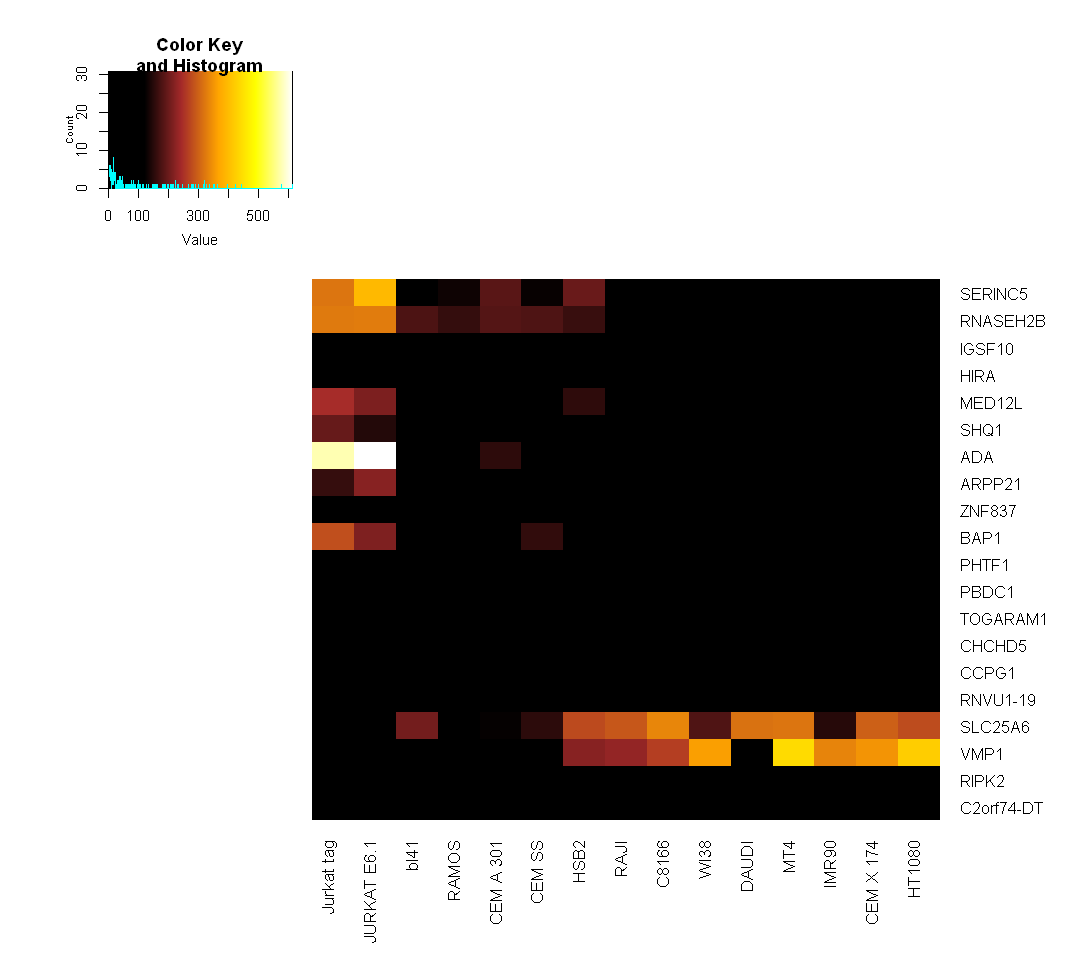

In [193]:
options(repr.plot.width=9, repr.plot.height=8)

selected_rpm_df <- result_df_sorted[c(top_positively_correlated,top_negatively_correlated),c(-1,-18)]
selected_rpm_df$positive_negative <- c(rep("red",10),rep("blue",10))

hm_matrix <- as.matrix(selected_rpm_df[,c(-16,-17)])
dimnames(hm_matrix) <- list(selected_rpm_df$gene_names,colnames(selected_rpm_df[,c(-16,-17)]))
par(mfrow=c(1,1),mar = c(8, 8, 8, 8), oma = c(2, 2, 2, 2))
heatmap.2(hm_matrix[,rev(infect_data$V3)], Rowv=FALSE, Colv=FALSE, dendrogram="none", trace="none", col=my_colors(1000))

### Plotting of each gene wrt cell lines ordered as decreasing infectivity ratio

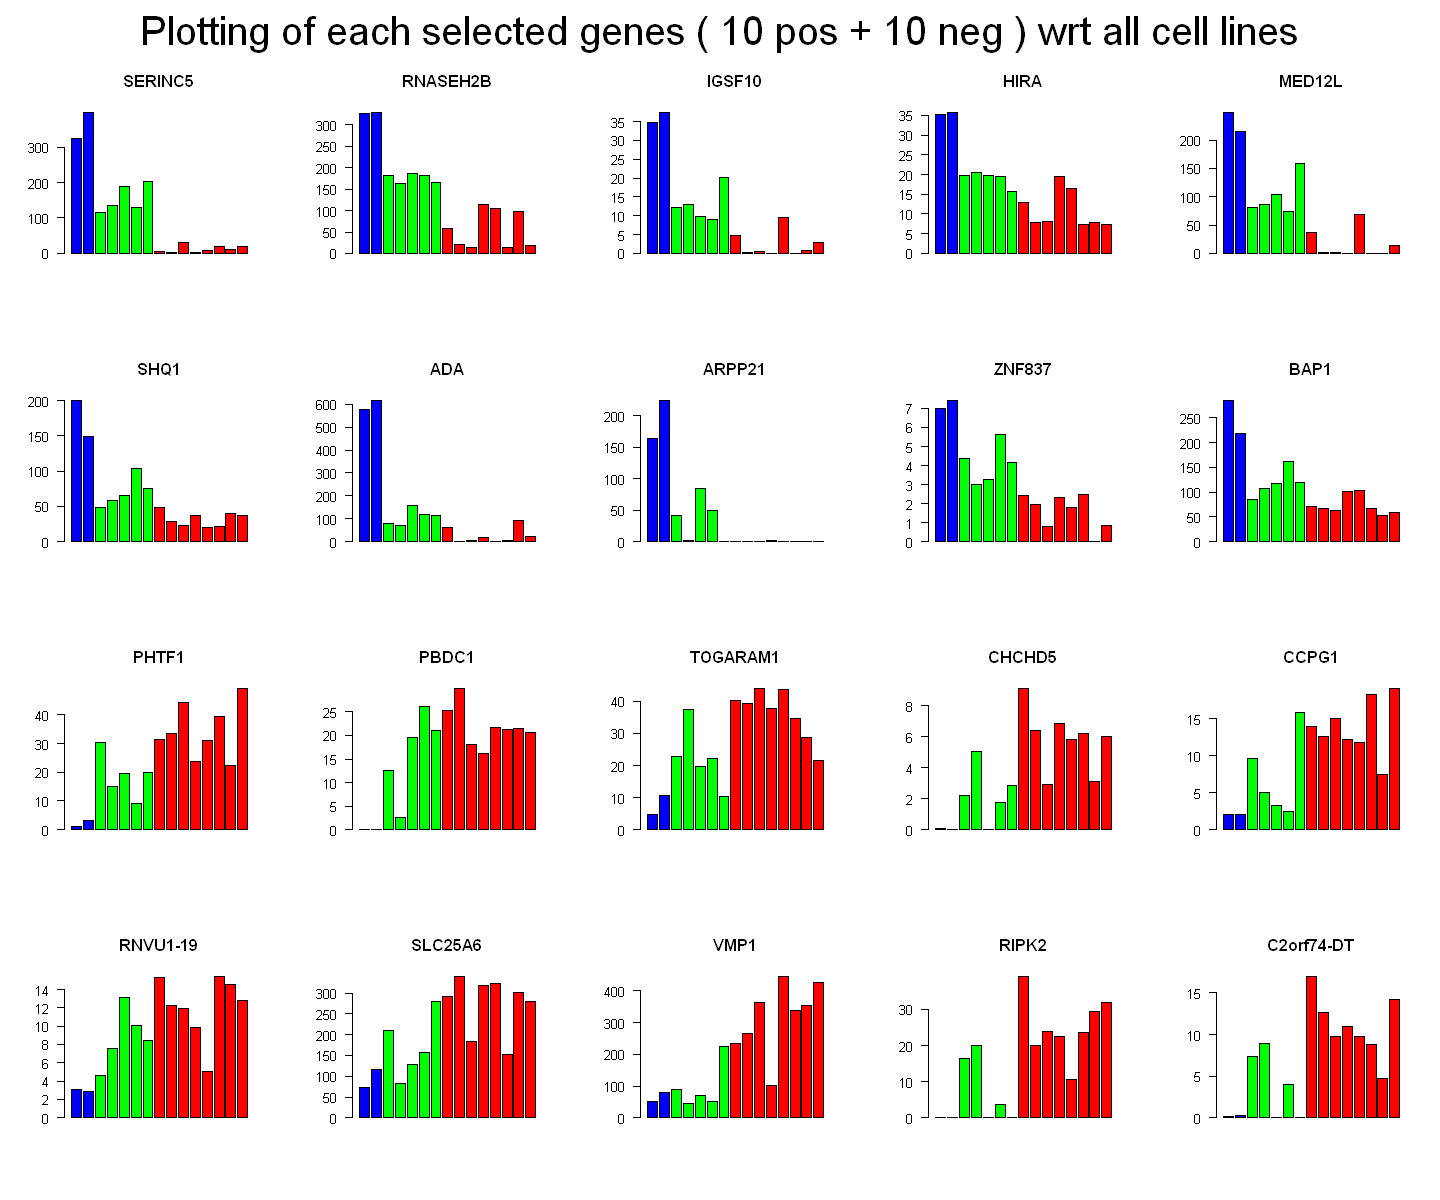

In [195]:
options(repr.plot.width=12, repr.plot.height=10)

plot_single_expression <- function(rownum){
plot_data <- as.vector(unlist(result_df_sorted[rownum,][,c(-1,-17,-18)][,rev(arrange(infect_data,V2)$V3)]))
barplot(plot_data, las=2, col=rev(arrange(infect_data,V2)$V4), main=result_df_sorted[rownum,]$gene_names)
}

par(mfrow = c(4, 5), oma=c(0,0,3,0))
for (i in c(top_positively_correlated,top_negatively_correlated)){
  plot_single_expression(i)
}

mtext("Plotting of each selected genes ( 10 pos + 10 neg ) wrt all cell lines",line=0, side=3, outer=TRUE, cex=2)

### Plotting of each cell line wrt top 10 postitively regulating gene expression ( yellow ) followed by top 10 negatively regulating gene expression ( magenta )

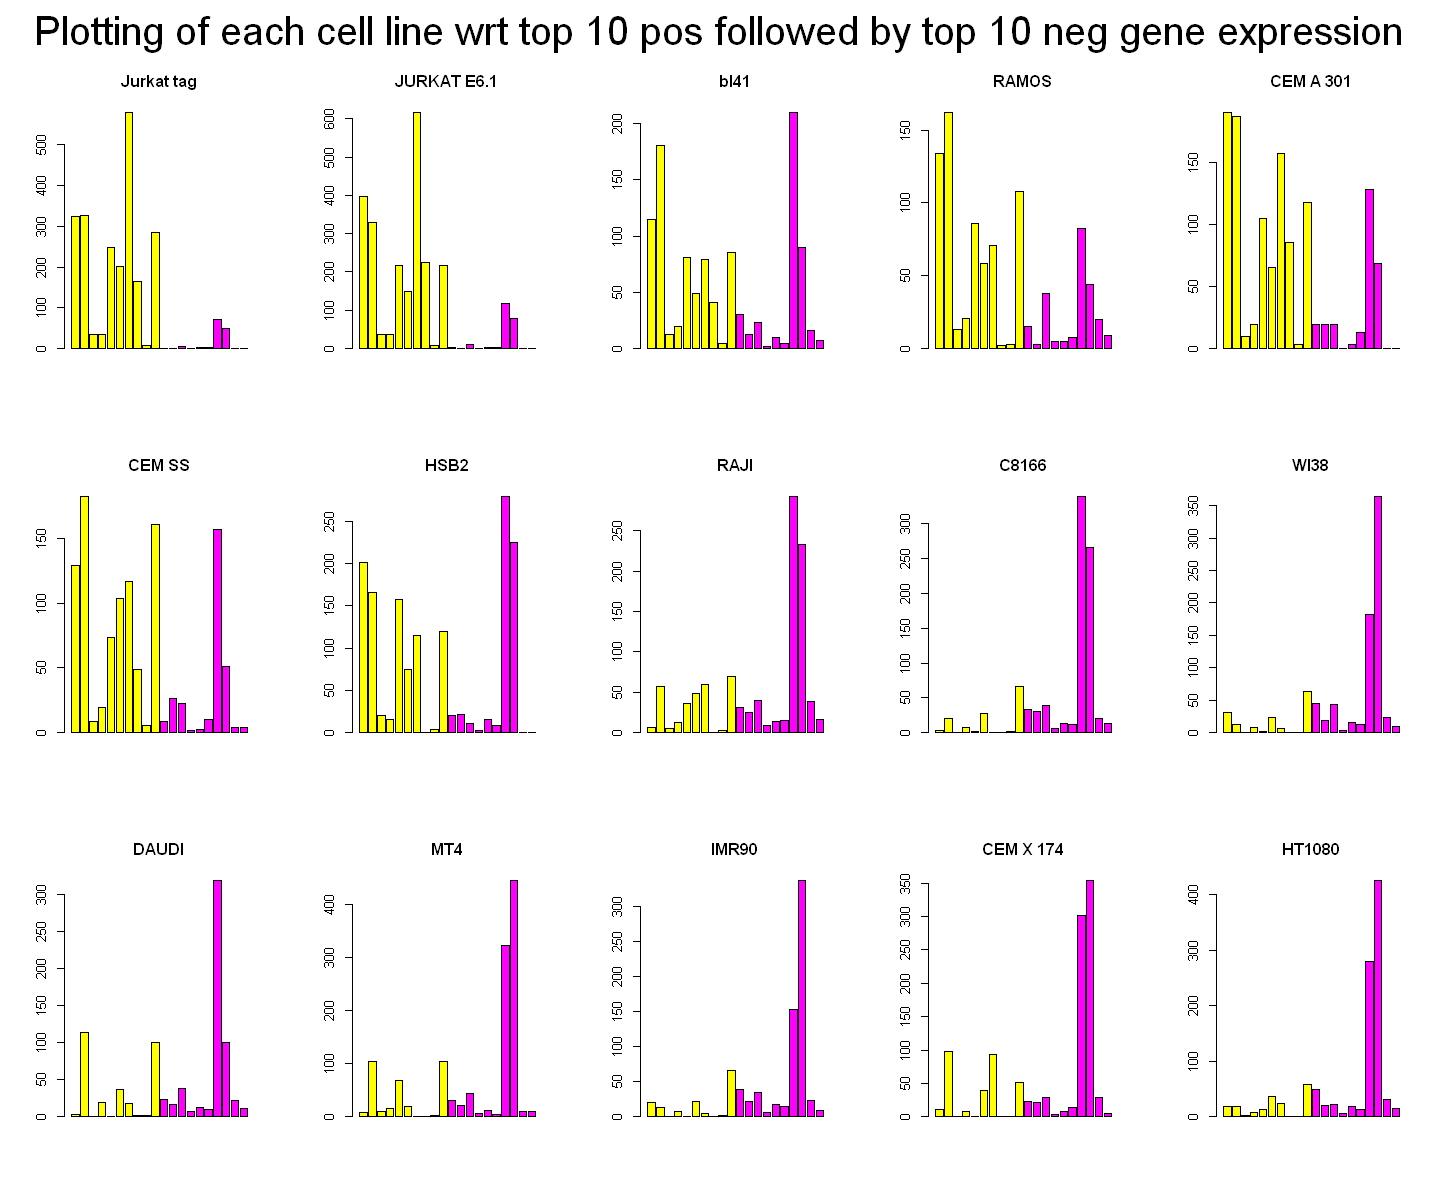

In [196]:
# cell line wise barplot
par(mfrow = c(3, 5), oma=c(0,0,3,0))
for (i in rev(arrange(infect_data,V2)$V3)){
barplot(selected_rpm_df[,i], col=c(rep("yellow",10),rep("magenta",10)), main=i)
}
mtext("Plotting of each cell line wrt top 10 pos followed by top 10 neg gene expression",line=0, side=3, outer=TRUE, cex=2)

### Cell line wise PCA with selected 20 genes

Importance of components:
                          Comp.1     Comp.2     Comp.3      Comp.4       Comp.5
Standard deviation     1.2401501 0.36686257 0.14572103 0.074468813 0.0236121943
Proportion of Variance 0.9044958 0.07915254 0.01248828 0.003261421 0.0003278919
Cumulative Proportion  0.9044958 0.98364831 0.99613659 0.999398010 0.9997259024
                             Comp.6      Comp.7       Comp.8       Comp.9
Standard deviation     0.0157986882 0.013117286 6.201899e-03 1.784016e-03
Proportion of Variance 0.0001467912 0.000101192 2.262077e-05 1.871783e-06
Cumulative Proportion  0.9998726936 0.999973886 9.999965e-01 9.999984e-01
                            Comp.10      Comp.11      Comp.12      Comp.13
Standard deviation     1.486180e-03 6.778050e-04 2.771130e-04 1.075734e-04
Proportion of Variance 1.298975e-06 2.701890e-07 4.516187e-08 6.805619e-09
Cumulative Proportion  9.999997e-01 9.999999e-01 1.000000e+00 1.000000e+00
                            Comp.14 Comp.15
Standard devia

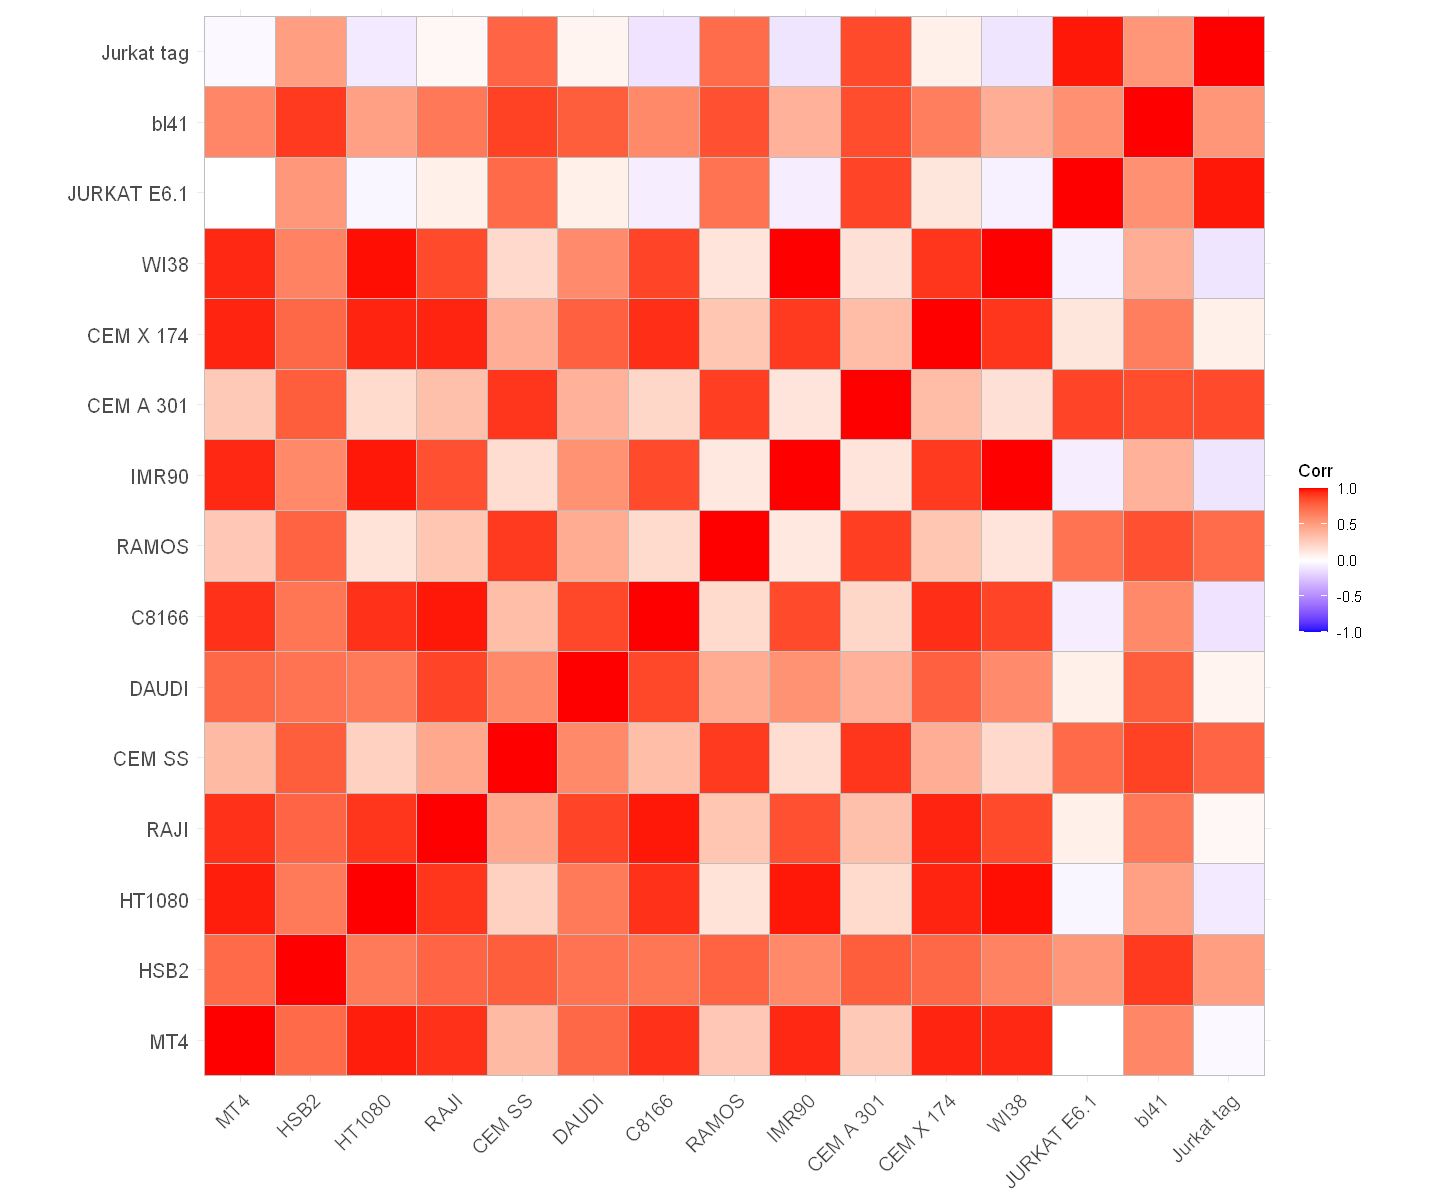

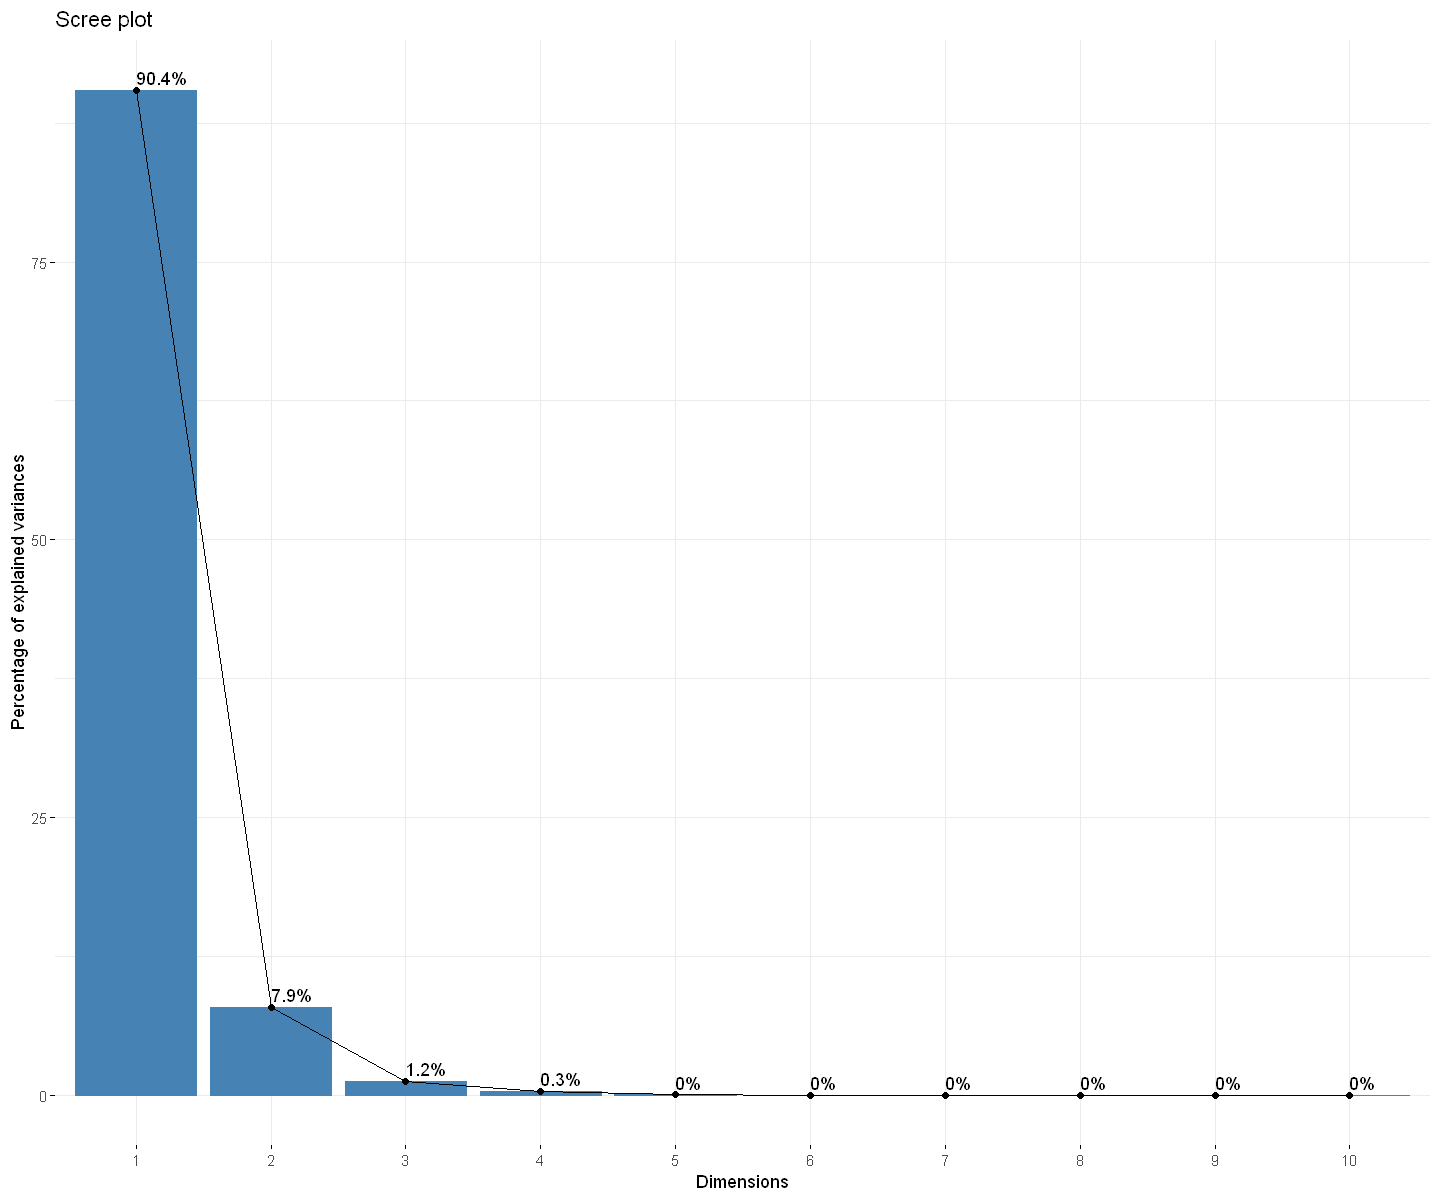

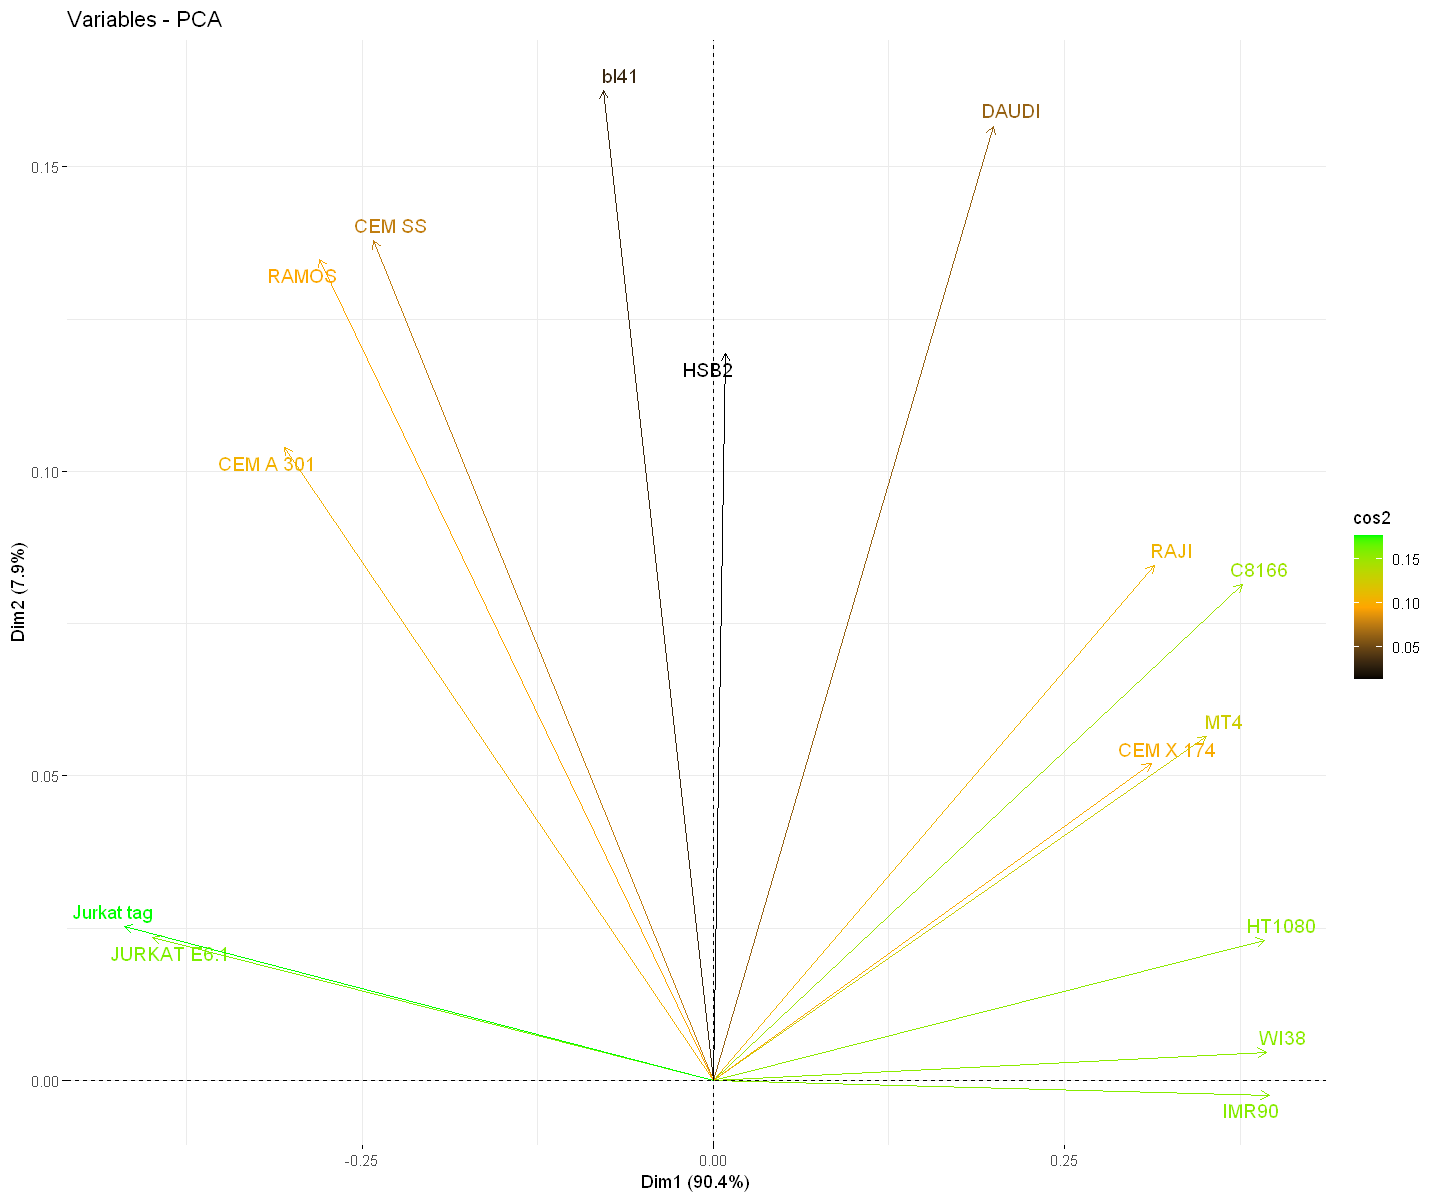

In [197]:
corr_matrix <- cor(selected_rpm_df[,c(-16,-17)])
ggcorrplot(corr_matrix)
data.pca <- princomp(corr_matrix)
summary(data.pca)
fviz_eig(data.pca, addlabels = TRUE)
fviz_pca_var(data.pca, col.var = "cos2",
             gradient.cols = c("black", "orange", "green"),
             repel = TRUE)

### Gene wise PCA with selected 20 genes

Importance of components:
                          Comp.1      Comp.2      Comp.3      Comp.4
Standard deviation     3.2985029 0.264903129 0.212520846 0.176757157
Proportion of Variance 0.9838526 0.006345567 0.004084128 0.002825207
Cumulative Proportion  0.9838526 0.990198148 0.994282276 0.997107483
                            Comp.5       Comp.6       Comp.7       Comp.8
Standard deviation     0.114376112 0.1009108285 0.0619880996 0.0541158735
Proportion of Variance 0.001182952 0.0009208138 0.0003474665 0.0002648169
Cumulative Proportion  0.998290435 0.9992112485 0.9995587150 0.9998235319
                             Comp.9      Comp.10      Comp.11      Comp.12
Standard deviation     3.239406e-02 2.348068e-02 1.454718e-02 1.081033e-02
Proportion of Variance 9.489143e-05 4.985601e-05 1.913613e-05 1.056755e-05
Cumulative Proportion  9.999184e-01 9.999683e-01 9.999874e-01 9.999980e-01
                            Comp.13      Comp.14      Comp.15 Comp.16 Comp.17
Standard deviation     4

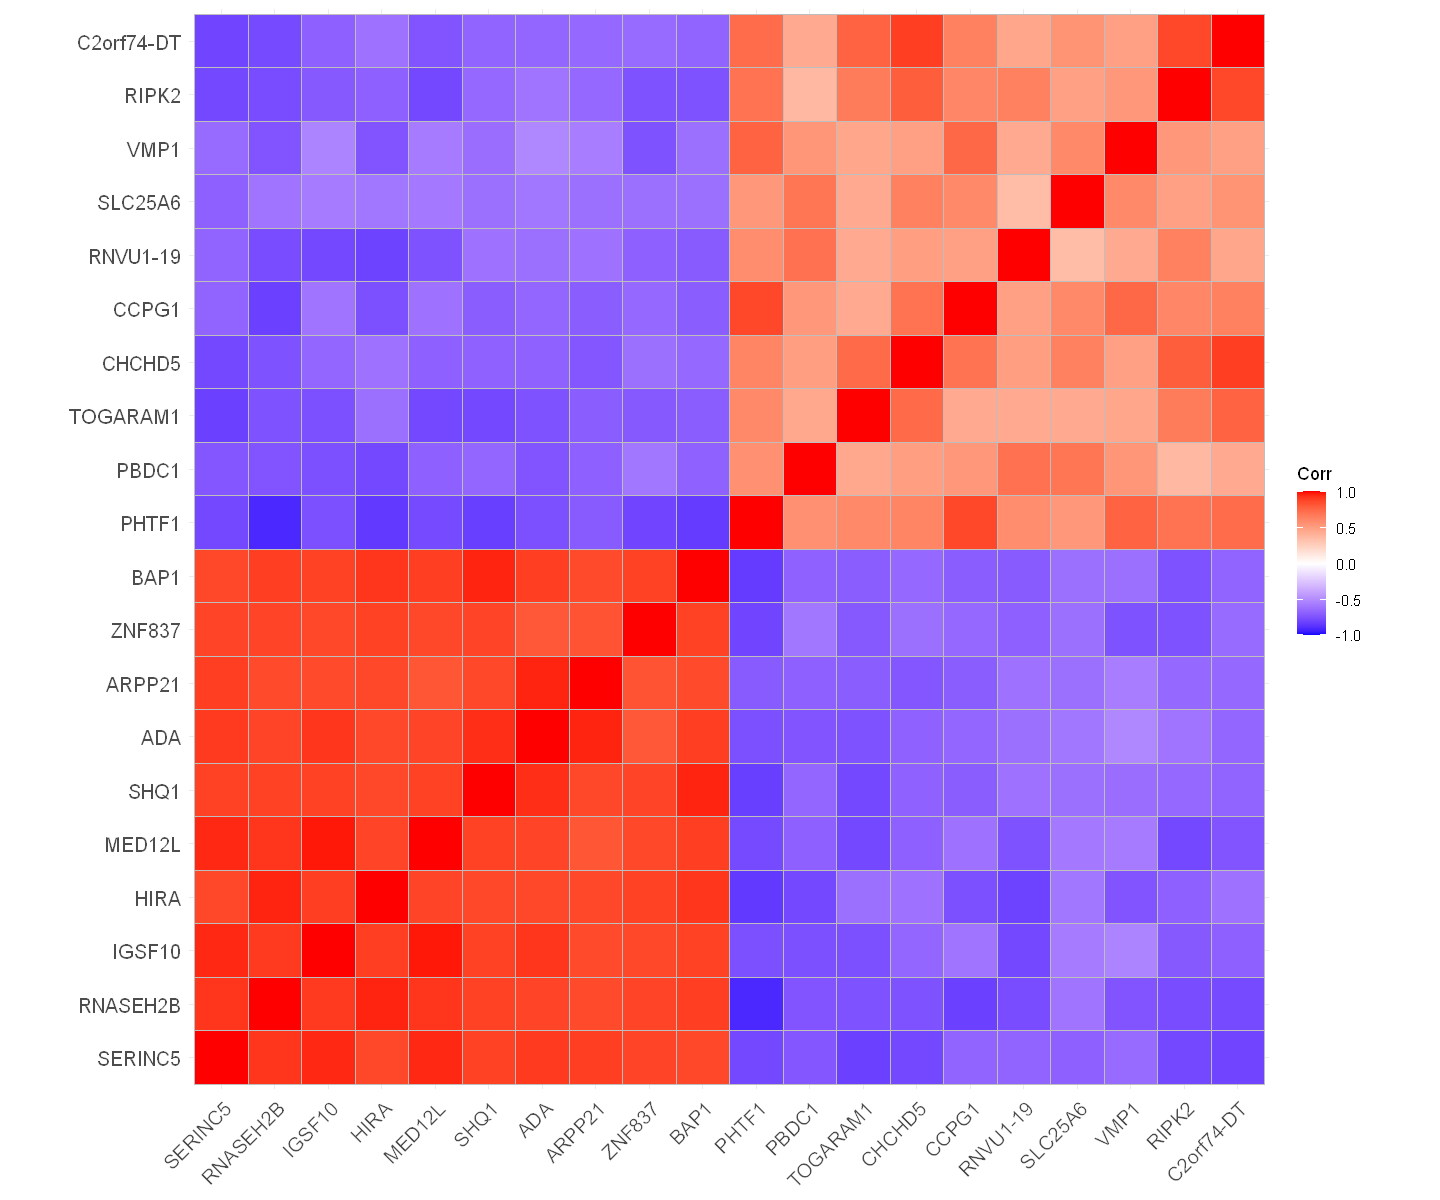

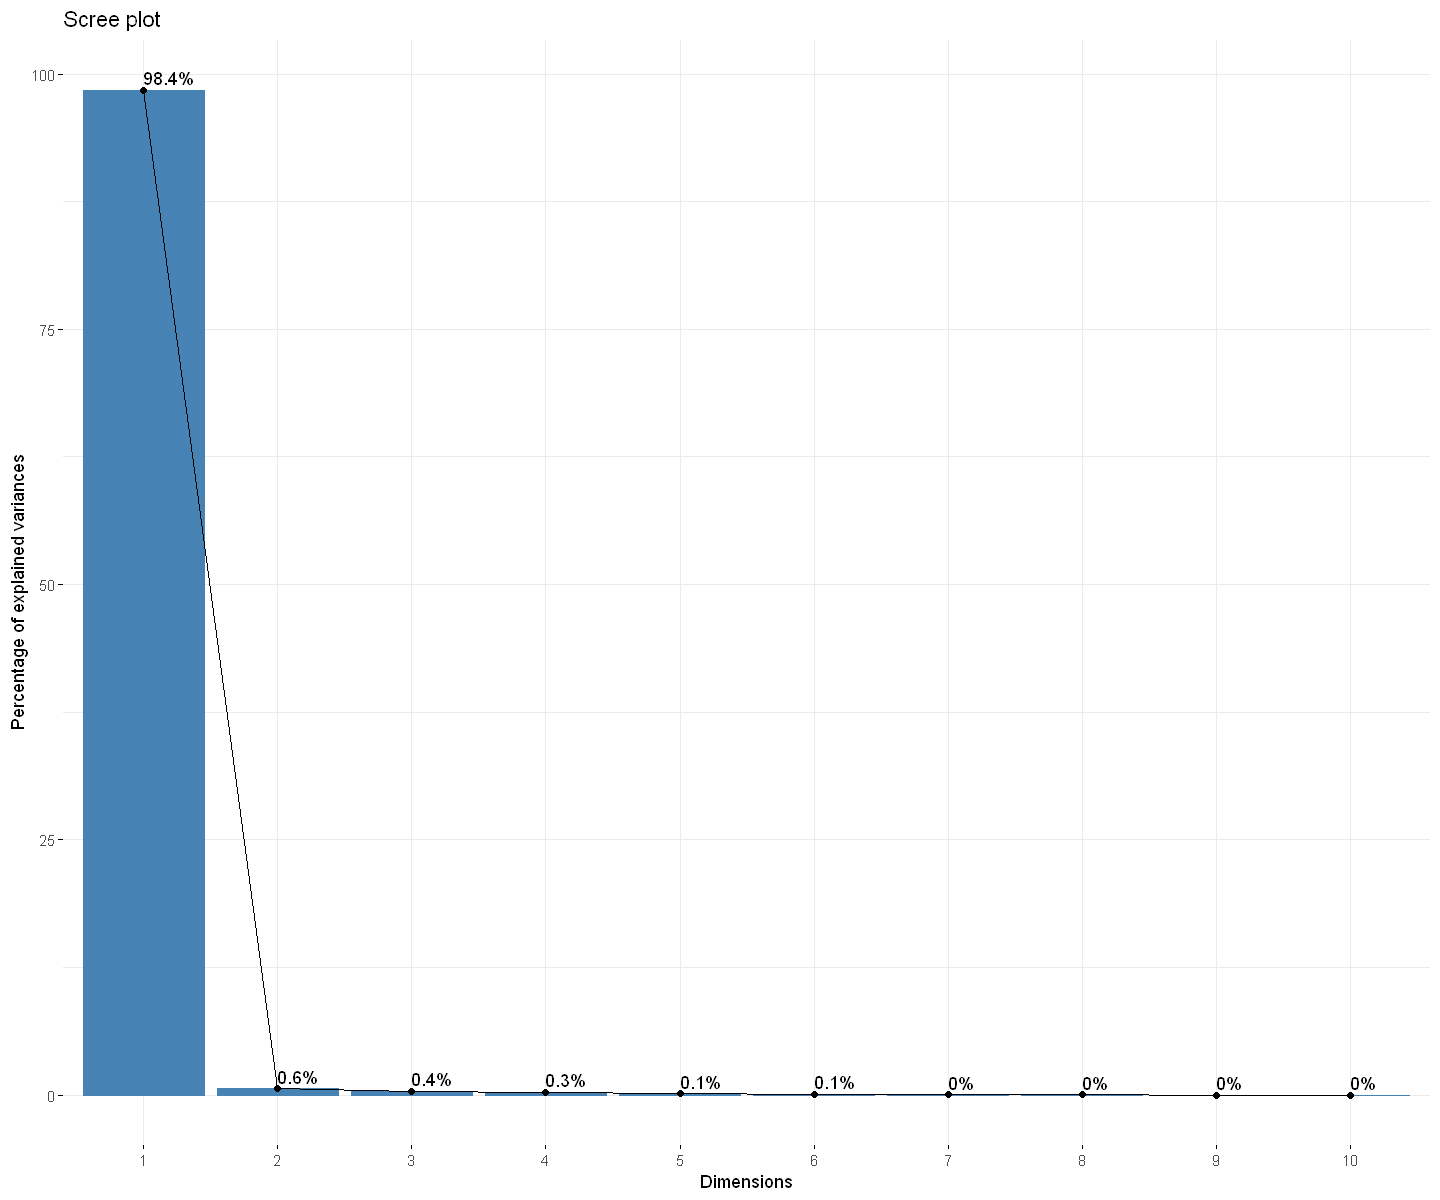

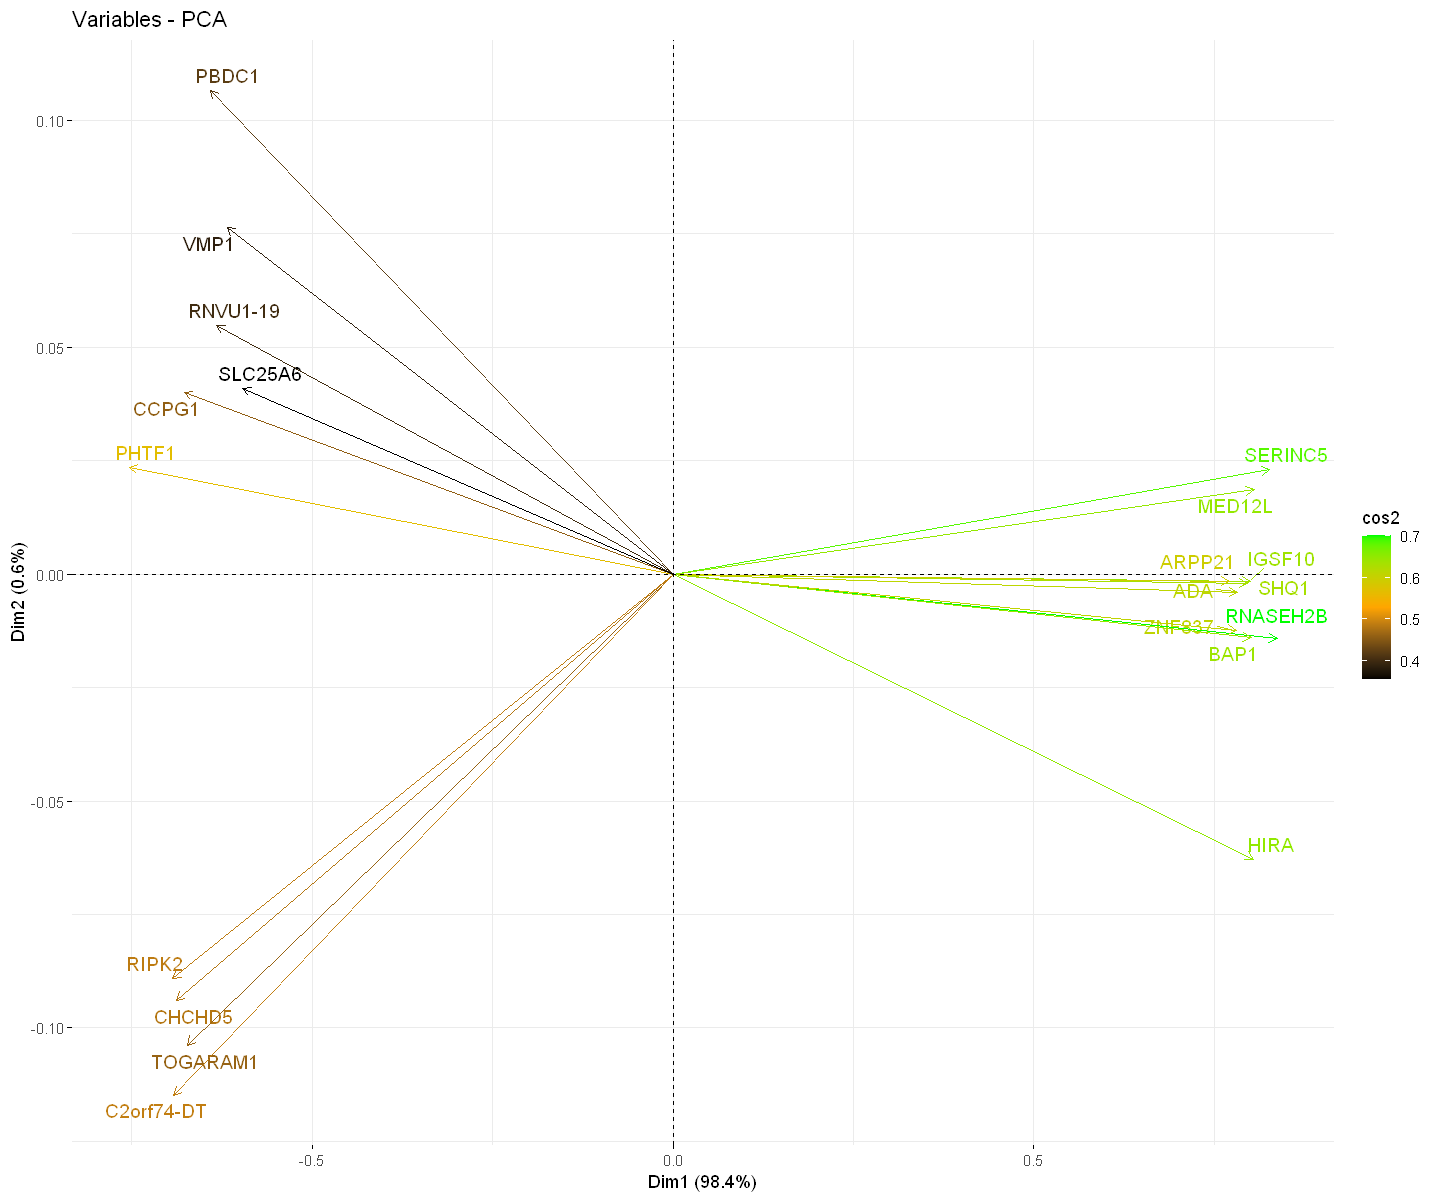

In [198]:
selected_rpm_transpose <- selected_rpm_df
rownames(selected_rpm_transpose) <- selected_rpm_transpose$gene_names
selected_rpm_transpose <- as.matrix(t(selected_rpm_transpose[,c(-16,-17)]))

corr_matrix <- cor(selected_rpm_transpose)
ggcorrplot(corr_matrix)
data.pca <- princomp(corr_matrix)
summary(data.pca)
fviz_eig(data.pca, addlabels = TRUE)
fviz_pca_var(data.pca, col.var = "cos2",
             gradient.cols = c("black", "orange", "green"),
             repel = TRUE)